# My Stock Forecasting Project 
## The Problem:
    Picking good stocks is the problem. I intend to build an app that'll pick the best stock from a list of 4 that the    user will input.
    Retail investing as grown by leaps and bounds over the past few years; laregly due to stock trading apps like Robinhood and the recent Wall Street Bets/Gamestop drama. More and more average folks are getting into investing looking to make a quick buck.
    But stock research is HARD. Wherever you look, there are just as many voices saying a stock is a buy as there are telling you it's a dud.
    So the idea here is to use some simple time series forecasting to create a quick and easy way to decide how to throw away some money.

# Getting started
## Step 1: Import libraries
    Since this is the big project, we'll be importing everything. And I mean everything.

In [1]:
import pandas as pd
import pandas.tseries
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
import datetime as dt
import yfinance as yf
import requests
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from sklearn.linear_model import LinearRegression
from iexfinance.stocks import Stock
import random
from trafalgar import*

# Step 2: The data
    Thanks to Yahoo Finance (the library) I can research the stock history for most assets being traded today.
    So the first step will be to run through the process on a test stock, then create the functions necessary to do it with any stock. Let's use Citigroup, since its stock symbol is only 1 letter:C.

In [2]:
c = yf.Ticker("C")

In [3]:
c.info

{'zip': '10013',
 'sector': 'Financial Services',
 'fullTimeEmployees': 214000,
 'longBusinessSummary': 'Citigroup Inc., a diversified financial services holding company, provides various financial products and services to consumers, corporations, governments, and institutions in North America, Latin America, Asia, Europe, the Middle East, and Africa. The company operates in two segments, Global Consumer Banking (GCB) and Institutional Clients Group (ICG). The GCB segment offers traditional banking services to retail customers through retail banking, Citi-branded cards, and Citi retail services. It also provides various banking, credit card, lending, and investment services through a network of local branches, offices, and electronic delivery systems. The ICG segment offers wholesale banking products and services, including fixed income and equity sales and trading, foreign exchange, prime brokerage, derivative, equity and fixed income research, corporate lending, investment banking an

In [4]:
# get historical market data, here max is 5 years.
c.history(period="max")

Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
1977-01-03   7.764117   7.814047   7.764117   7.814047     47952       0.00   
1977-01-04   7.814046   7.839010   7.789080   7.839010     34217       0.00   
1977-01-05   7.839010   7.839010   7.764115   7.789080     15422       0.00   
1977-01-06   7.764115   7.764115   7.664254   7.739149     39036       0.00   
1977-01-07   7.739149   7.764114   7.664254   7.764114     20482       0.00   
...               ...        ...        ...        ...       ...        ...   
2021-07-26  65.967420  67.337189  65.967420  67.267708  16426200       0.00   
2021-07-27  66.582827  67.893043  66.285048  67.476158  17122100       0.00   
2021-07-28  67.813631  68.101483  66.989781  67.595261  20267500       0.00   
2021-07-29  68.200738  69.064293  67.902966  68.299995  22261700       0.00   
2021-07-30  67.919998  68.519997  67.239998  67.620003  18074300       0.51   

            Stock Splits  
Date                      
1977-01-03           0.0  
1977-01-04           0.0  
1977-01-05           0.0  
1977-01-06           0.0  
1977-01-07           0.0  
...                  ...  
2021-07-26           0.0  
2021-07-27           0.0  
2021-07-28           0.0  
2021-07-29           0.0  
2021-07-30           0.0  

[11239 rows x 7 columns]

Well, no problem getting enough data for this one, unless my math is wrong, this is 44 years of data. Ok, let's do a train-test split and start predicting.....just kidding. One of the lessons learned from my last project is using too much data in my training set.
What we'll need to do is determine the period for our predictions: how far in advance do we intend to predict? I'd say no more than a month.

In [5]:
df=c.history(period="max")

In [6]:
df.tail()

Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
2021-07-26  65.967420  67.337189  65.967420  67.267708  16426200       0.00   
2021-07-27  66.582827  67.893043  66.285048  67.476158  17122100       0.00   
2021-07-28  67.813631  68.101483  66.989781  67.595261  20267500       0.00   
2021-07-29  68.200738  69.064293  67.902966  68.299995  22261700       0.00   
2021-07-30  67.919998  68.519997  67.239998  67.620003  18074300       0.51   

            Stock Splits  
Date                      
2021-07-26           0.0  
2021-07-27           0.0  
2021-07-28           0.0  
2021-07-29           0.0  
2021-07-30           0.0

What I want to figure out here is how we're going to split the data for training and testing; different splits give different results (better or worse). So let's make some loops and test a number of different training and testing values, and see what works best.

In [7]:
df1=df['Close']

In [8]:
trains=[14,30,60,180,360,720,900]
tests=[7,14,21,28,56]

In [9]:
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))

In [10]:
df1.isna().sum()

0

As the output I'd like to make a dataframe with some performance metrics, and see what split gives us the lowest errors.

In [11]:
cols=['Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']

In [12]:
outs = pd.DataFrame(columns=cols)

In [13]:
for test_val in tests:
    for train_val in trains:
        val_a=test_val+train_val
        df_mod=df1.tail(val_a)
        train_data, test_data = temporal_train_test_split(df_mod, test_size=test_val)
        test_sq=test_data.squeeze()
        train_sq=train_data.squeeze()
        arima = pm.auto_arima(train_sq,error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100,seasonal=True, m=1)
        y_pred = arima.predict(n_periods=test_data.shape[0])
        y_true=test_data
        ev_score= metrics.explained_variance_score(y_true, y_pred)
        mae= metrics.mean_absolute_error(y_true, y_pred)
        rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)
        r2 = metrics.r2_score(y_true, y_pred)
        outs.loc[len(outs.index)] = [train_val,test_val,ev_score,mae,rmse,r2]       

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=54.024, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=54.973, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=50.876, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=48.425, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=159.714, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=50.112, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=50.109, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=52.093, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.709 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=99.273, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=98.185, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=97.880, Time=0.02 sec
 ARIMA(0,1

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=90.598, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.412 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=181.716, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=331.809, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=185.880, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=275.925, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=687.274, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=179.892, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=231.454, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=184.500, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=181.757, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=212.362, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=183.570, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=178.986, Time=0.27 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=262.477, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=687.839, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=171.418, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=224.973, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=175.910, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=173.406, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=201.786, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=174.505, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=175.416, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=179.120, Time=0.04 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 1.024 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=581.535, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=581.942, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : A

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1440.821, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.773 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2558.293, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2568.573, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2564.083, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2565.378, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2566.584, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2556.588, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2554.591, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2556.587, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2561.849, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2552.601, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2563.392, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]    

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3067.502, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3078.165, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3071.356, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3072.828, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3076.226, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3066.071, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3064.117, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3066.050, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3069.788, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3062.176, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3070.901, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3064.129, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3064.108, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3067.861, Time=0.06 sec
 ARIMA(1,1,3)(0

In [14]:
outs.head()

Train_Len  Test_Len   Exp_var       MAE      RMSE        R2
0       14.0       7.0 -0.063019  0.565022  0.785417 -0.374123
1       30.0       7.0  0.252359  1.005052  1.160071 -1.997739
2       60.0       7.0  0.142844  0.827495  0.984631 -1.159590
3      180.0       7.0 -0.441985  0.732044  0.826802 -0.522748
4      360.0       7.0  0.128665  0.501830  0.697033 -0.082258

In [15]:
outs[outs.MAE == outs.MAE.min()]

Train_Len  Test_Len   Exp_var       MAE     RMSE        R2
6      900.0       7.0  0.102423  0.499059  0.69529 -0.076853

In [16]:
outs[outs.RMSE == outs.RMSE.min()]

Train_Len  Test_Len   Exp_var       MAE     RMSE        R2
6      900.0       7.0  0.102423  0.499059  0.69529 -0.076853

In [17]:
outs[outs.R2 == outs.R2.min()]

Train_Len  Test_Len    Exp_var        MAE       RMSE         R2
21       14.0      28.0 -10.079242  10.567218  11.867525 -52.488857

# STONKS!!!

Now that we have a nice little bit of code to test various train/test splits, let's test it out on some more stocks. Finding files for the S&P 500, NASDAQ and Dow were very easy. So we can read them, and go through them all and see what we come up with.

In [18]:
sp_500=pd.read_csv('Data/constituents_csv.csv')

In [19]:
nsdq=pd.read_csv('Data/nasdaq.csv')

In [20]:
dow_30=pd.read_excel('Data/dow-jones-industrial-average-components.xls')

In [21]:
sp_500.head()

Unnamed: 0 Symbol                 Name                  Sector
0           0    MMM                   3M             Industrials
1           1    ABT  Abbott Laboratories             Health Care
2           2   ABBV               AbbVie             Health Care
3           3   ABMD              Abiomed             Health Care
4           4    ACN            Accenture  Information Technology

In [22]:
sp_500.isna().sum()

Unnamed: 0    0
Symbol        0
Name          0
Sector        0
dtype: int64

In [23]:
nsdq.head()

Unnamed: 0 Symbol                   Company Name
0           1    AAL  American Airlines Group, Inc.
1           2   AAME  Atlantic American Corporation
2           3   AAOI  Applied Optoelectronics, Inc.
3           4   AAON                     AAON, Inc.
4           5   AAPL                     Apple Inc.

In [24]:
nsdq.isna().sum()

Unnamed: 0      0
Symbol          0
Company Name    0
dtype: int64

In [25]:
dow_30.head()

Company Name Ticker Symbol  Weighting %
0                3M Company           MMM     0.038022
1  American Express Company           AXP     0.025567
2                Amgen Inc.          AMGN     0.048569
3                Apple Inc.          AAPL     0.028752
4          Caterpillar Inc.           CAT     0.039120

In [26]:
dow_30.isna().sum()

Company Name     0
Ticker Symbol    0
Weighting %      0
dtype: int64

In [27]:
dow_30.head()

Company Name Ticker Symbol  Weighting %
0                3M Company           MMM     0.038022
1  American Express Company           AXP     0.025567
2                Amgen Inc.          AMGN     0.048569
3                Apple Inc.          AAPL     0.028752
4          Caterpillar Inc.           CAT     0.039120

In [28]:
new_cols=['Name','Symbol','Weight%']
dow_30.columns=new_cols

In [29]:
dow_30.head()

Name Symbol   Weight%
0                3M Company    MMM  0.038022
1  American Express Company    AXP  0.025567
2                Amgen Inc.   AMGN  0.048569
3                Apple Inc.   AAPL  0.028752
4          Caterpillar Inc.    CAT  0.039120

What I want to do now is iterate through a variety of stocks, testing the various train/test splits, and coming up with a dataframe containing the stock symbol, the best train/test split, and the metrics.

In [30]:
stock = yf.Ticker(sp_500['Symbol'][0])

In [31]:
stock_df=stock.history(period='max')

In [32]:
stock_df.iloc[::-1]

Open        High         Low       Close   Volume  \
Date                                                                  
2021-07-30  198.000000  199.240005  197.199997  197.940002  1910300   
2021-07-29  200.000000  200.000000  197.940002  198.169998  2120200   
2021-07-28  199.320007  200.369995  198.100006  198.279999  2139100   
2021-07-27  197.210007  201.059998  194.910004  200.470001  2999900   
2021-07-26  200.449997  202.740005  199.929993  201.669998  2408500   
...                ...         ...         ...         ...      ...   
1970-01-08    1.492125    1.515440    1.488795    1.512109   304000   
1970-01-07    1.483799    1.495456    1.480468    1.492126   164800   
1970-01-06    1.468811    1.483799    1.467146    1.483799   176000   
1970-01-05    1.462150    1.470477    1.462150    1.468811   446400   
1970-01-02    1.460485    1.468811    1.458819    1.460485    72000   

            Dividends  Stock Splits  
Date                                 
2021-07-30        0.0           0.0  
2021-07-29        0.0           0.0  
2021-07-28        0.0           0.0  
2021-07-27        0.0           0.0  
2021-07-26        0.0           0.0  
...               ...           ...  
1970-01-08        0.0           0.0  
1970-01-07        0.0           0.0  
1970-01-06        0.0           0.0  
1970-01-05        0.0           0.0  
1970-01-02        0.0           0.0  

[13011 rows x 7 columns]

In [33]:
stock_df.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

Let's try this out through the first 5 stocks in the dow dataframe

In [34]:
dow_5=dow_30.head()

In [35]:
dow_5

Name Symbol   Weight%
0                3M Company    MMM  0.038022
1  American Express Company    AXP  0.025567
2                Amgen Inc.   AMGN  0.048569
3                Apple Inc.   AAPL  0.028752
4          Caterpillar Inc.    CAT  0.039120

In [36]:
cols2=['Symbol','Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()

Empty DataFrame
Columns: [index, Symbol, Train_Len, Test_Len, Exp_var, MAE, RMSE, R2]
Index: []

In [37]:
fin_results=pd.DataFrame()

In [38]:
def tt_test (asset, train_list, test_list):
    """This function will take in a financial asset (stock, etf) as well as 2 lists of integers (training and testing days).
    Then the asset will be looked up through yahoo finance and gather the price history. It will then run through the values
    of the training and testing lists and run auto arima models on all of them. It will record the metrics and return a
    dataframe with all the results."""
    
    stock = yf.Ticker(asset)
    df1=stock.history(period='5y')
    df=df1['Close']
    print("Processing: ",stock)
    if len(df)<(train_list[0]+test_list[0]):
        print ('Not enough historical data to model.')
        return None
    else:
        
    
        for test_val in test_list:
            for train_val in train_list:
                val_a=test_val+train_val
                df_mod=df.tail(val_a)
                train_data, test_data = temporal_train_test_split(df_mod, test_size=test_val)
                test_sq=test_data.squeeze()
                train_sq=train_data.squeeze()
                arima = pm.auto_arima(train_sq,error_action='ignore', trace=True,
                        suppress_warnings=True, maxiter=100,seasonal=True, m=1)
                y_pred = arima.predict(n_periods=test_data.shape[0])
                y_true=test_data
                ev_score= metrics.explained_variance_score(y_true, y_pred)
                mae= metrics.mean_absolute_error(y_true, y_pred)
                rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)
                r2 = metrics.r2_score(y_true, y_pred)        
                reslts.loc[len(reslts.index)] = [stock,train_val,test_val,ev_score,mae,rmse,r2]             

        return reslts

In [39]:
cols2=['Symbol','Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in dow_5['Symbol']:
    stock_res_d5 = tt_test(each,trains,tests)
    print (stock_res_d5[(stock_res_d5.MAE == stock_res_d5.MAE.min())])


Processing:  yfinance.Ticker object <MMM>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=64.048, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=57.284, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=59.127, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=59.088, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=190.069, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=61.066, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.267 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=139.404, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=158.962, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=133.698, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=145.659, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=404.588, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=135.804, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1820.379, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1821.273, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1817.411, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1818.238, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1818.678, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1819.067, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1819.091, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1819.343, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1820.131, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1819.366, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.703 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3590.447, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercep

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.264 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=805.445, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=807.131, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=806.932, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=805.060, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=804.370, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=803.284, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=801.985, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=803.635, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=805.262, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=802.165, Time=0.01 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.670 seconds
Performing stepwise search to m

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=276.744, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=278.601, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=278.407, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=276.172, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.347 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=878.452, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=880.053, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=879.854, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=881.004, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.584 seconds
Performing stepwise search to minimize 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3373.989, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3391.461, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3387.700, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3388.342, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3390.569, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3388.125, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3388.361, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3386.478, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3369.451, Time=0.99 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3384.735, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3372.127, Time=0.95 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3369.990, Time=0.83 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3380.984, Time=0.32 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3371.555, Time=1.04 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.50 sec

Best model:  A

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4078.372, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4083.580, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4061.849, Time=0.88 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 8.025 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=63.693, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=65.139, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=64.900, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=184.466, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=67.693, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.345 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=132.769, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=134.044, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=136.012,

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3360.881, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3361.195, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3357.545, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3338.935, Time=0.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3355.924, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3355.468, Time=0.44 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3352.812, Time=0.30 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3342.183, Time=0.77 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3337.771, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3354.693, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3343.675, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3338.692, Time=0.67 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3354.512, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3359.710, Time=0.13 sec
 ARIMA(1,1,4)(0

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4784.391, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4783.903, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4785.877, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4781.678, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4783.209, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4782.712, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4782.296, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4784.693, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.091 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=66.808, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=69.371, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=63.523, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=63.055, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=195.584, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] interce

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=914.074, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=917.344, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=916.402, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=918.182, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=910.294, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=913.712, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=914.782, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=912.039, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=912.120, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=915.375, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=914.440, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=916.219, Time=0.05 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=911.631, Time=0.19 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 2.215 seconds
Performing stepwi

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3919.840, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3919.144, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3921.113, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3917.547, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3918.299, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3917.611, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3918.548, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3919.575, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.579 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4792.289, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4780.841, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4781.514, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4790.982, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] int

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=119.227, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=120.571, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=120.232, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=120.708, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.332 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=245.652, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=282.062, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=264.679, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=241.161, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=241.707, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=240.968, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=244.003, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3501.552, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3526.449, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3514.742, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3515.580, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3528.471, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3517.926, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3517.927, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.08 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3521.887, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3515.936, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3519.847, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3519.870, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3523.898, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3522.815, Time=0.11 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.971 seconds
Perf

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=819.940, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=819.980, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=819.972, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=818.333, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=821.972, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.509 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1685.699, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1685.970, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1680.141, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1680.738, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1685.268, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1681.742, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1681.700, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercep

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=159.190, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=160.838, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=160.738, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=158.590, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=162.694, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.298 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=309.305, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=309.469, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=309.325, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=307.856, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=311.321, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.299 seconds
Performing stepwise search to m

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1916.425, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1926.633, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1926.164, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1926.503, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1926.262, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1927.454, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1927.924, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1917.099, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1927.065, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1928.393, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1929.359, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1916.313, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1927.075, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)

 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1918.229, Time=0.32 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1916.852, Time=0.29 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1921.571, Time=0.30 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1922.783, Time=0.24 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1916.555, Time=0.18 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1921.514, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1918.458, Time=0.19 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1928.591, Time=0.07 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=1922.533, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1917.636, Time=0.51 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=inf, Time=0.91 sec

Best model:  ARIMA(2,1,4)(0,0,0)[0

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1929.889, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1918.402, Time=0.56 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1913.691, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1925.901, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1927.322, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1926.466, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1928.254, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1929.107, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1916.920, Time=0.39 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.021 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3603.411, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   :

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3578.474, Time=0.74 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3593.147, Time=0.26 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3579.894, Time=0.77 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3582.056, Time=1.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3578.340, Time=0.94 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3592.702, Time=0.30 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3579.751, Time=0.49 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3587.396, Time=0.55 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3581.612, Time=1.01 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3578.421, Time=0.47 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 7.778 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4410.601, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4421.841, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4421.287, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0

In [40]:
stock_res_d5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 0 to 174
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Symbol     175 non-null    object 
 1   Train_Len  175 non-null    object 
 2   Test_Len   175 non-null    object 
 3   Exp_var    175 non-null    float64
 4   MAE        175 non-null    float64
 5   RMSE       175 non-null    float64
 6   R2         175 non-null    float64
dtypes: float64(4), object(3)
memory usage: 10.9+ KB


In [41]:
stock_res_d5.head()

Symbol Train_Len Test_Len       Exp_var       MAE  \
0  yfinance.Ticker object <MMM>        14        7 -2.220446e-16  1.294898   
1  yfinance.Ticker object <MMM>        30        7  1.763104e-01  1.186575   
2  yfinance.Ticker object <MMM>        60        7  1.585954e-01  1.241890   
3  yfinance.Ticker object <MMM>       180        7 -5.650815e-01  2.040663   
4  yfinance.Ticker object <MMM>       360        7  2.932009e-02  1.437196   

       RMSE        R2  
0  1.410027 -0.115012  
1  1.263835  0.104211  
2  1.387447 -0.079586  
3  2.517961 -2.555681  
4  1.729886 -0.678262

In [42]:
stock_res_d5.tail()

Symbol Train_Len Test_Len       Exp_var        MAE  \
170  yfinance.Ticker object <CAT>        60       56  2.220446e-16  17.051754   
171  yfinance.Ticker object <CAT>       180       56 -1.707231e+00  32.501463   
172  yfinance.Ticker object <CAT>       360       56 -7.564317e-01  24.303344   
173  yfinance.Ticker object <CAT>       720       56 -3.804639e-01  20.754523   
174  yfinance.Ticker object <CAT>       900       56 -3.200147e-01  20.305426   

          RMSE        R2  
170  20.509356 -1.525160  
171  38.721714 -8.001067  
172  29.521898 -4.232068  
173  25.213660 -2.816424  
174  24.642429 -2.645456

I don't like that 'yfinance Ticker object' at the beginning of each entry. So let's get rid of that.

In [43]:
for each in stock_res_d5.index:
    stock_res_d5['Symbol'][each]=str(stock_res_d5['Symbol'][each])
    stock_res_d5['Symbol'][each]=stock_res_d5['Symbol'][each].replace('>','')
    stock_res_d5['Symbol'][each]=stock_res_d5['Symbol'][each].split('<', 1)[-1]

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We get some warnings with that, but it works.

In [44]:
stock_res_d5

Symbol Train_Len Test_Len       Exp_var        MAE       RMSE        R2
0      MMM        14        7 -2.220446e-16   1.294898   1.410027 -0.115012
1      MMM        30        7  1.763104e-01   1.186575   1.263835  0.104211
2      MMM        60        7  1.585954e-01   1.241890   1.387447 -0.079586
3      MMM       180        7 -5.650815e-01   2.040663   2.517961 -2.555681
4      MMM       360        7  2.932009e-02   1.437196   1.729886 -0.678262
..     ...       ...      ...           ...        ...        ...       ...
170    CAT        60       56  2.220446e-16  17.051754  20.509356 -1.525160
171    CAT       180       56 -1.707231e+00  32.501463  38.721714 -8.001067
172    CAT       360       56 -7.564317e-01  24.303344  29.521898 -4.232068
173    CAT       720       56 -3.804639e-01  20.754523  25.213660 -2.816424
174    CAT       900       56 -3.200147e-01  20.305426  24.642429 -2.645456

[175 rows x 7 columns]

Now let's look at the first stock in the dataframe, 3M. I'll pull it out and make it a generic dataframe.

In [45]:
df_x=pd.DataFrame(columns=stock_res_d5.columns)

Since the results dataframe is 175 entries long, and 175/5 is 35, taking the first 35 entries will get us all of 3M.

In [46]:
df_x=stock_res_d5.loc[stock_res_d5.index[0:35]]

In [47]:
df_x.sort_values(by=['MAE']).head()

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
1    MMM        30        7  1.763104e-01  1.186575  1.263835  0.104211
2    MMM        60        7  1.585954e-01  1.241890  1.387447 -0.079586
0    MMM        14        7 -2.220446e-16  1.294898  1.410027 -0.115012
9    MMM        60       14  5.522828e-02  1.399618  1.627439  0.001856
8    MMM        30       14  0.000000e+00  1.403572  1.628964 -0.000016

In [48]:
df_y=df_x.sort_values(by=['MAE']).head(2)

In [49]:
df_y

Symbol Train_Len Test_Len   Exp_var       MAE      RMSE        R2
1    MMM        30        7  0.176310  1.186575  1.263835  0.104211
2    MMM        60        7  0.158595  1.241890  1.387447 -0.079586

In [50]:
df_y=pd.DataFrame(columns=stock_res_d5.columns)

In [51]:
a=0
while a<=(len(stock_res_d5)-35):
    df_x=stock_res_d5.loc[stock_res_d5.index[a:(a+35)]]
    df_ph=df_x.sort_values(by=['MAE']).head(2)
    df_y=pd.concat([df_y,df_ph])
    a+=35

In [52]:
df_y

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
1      MMM        30        7  1.763104e-01  1.186575  1.263835  0.104211
2      MMM        60        7  1.585954e-01  1.241890  1.387447 -0.079586
36     AXP        30        7  0.000000e+00  1.119999  1.397444 -0.447730
37     AXP        60        7  0.000000e+00  1.119999  1.397444 -0.447730
71    AMGN        30        7 -2.220446e-16  1.382860  1.903345 -0.073219
73    AMGN       180        7 -2.220446e-16  1.382860  1.903345 -0.073219
111   AAPL       900        7 -2.446790e-01  1.436594  1.760489 -0.614683
110   AAPL       720        7 -2.727580e-01  1.449004  1.751026 -0.597370
141    CAT        30        7  0.000000e+00  1.488571  1.866133 -0.151630
142    CAT        60        7  0.000000e+00  1.488571  1.866133 -0.151630

Ok, so I managed to get some data on train/test splits, but I still need more. So far it looks like 30 and 60 are leading on the training set.  Clearly 7 days for the test set is winning. But let's run through the entire dow 30, and see what that'll get us.

In [53]:
df_y['Train_Len'].value_counts()

30     4
60     3
900    1
180    1
720    1
Name: Train_Len, dtype: int64

In [54]:
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in dow_30['Symbol']:
    stock_res_d30 = tt_test(each,trains,tests)
    print (stock_res_d30[(stock_res_d30.MAE == stock_res_d30.MAE.min())])
for each in stock_res_d30.index:
    stock_res_d30['Symbol'][each]=str(stock_res_d30['Symbol'][each])
    stock_res_d30['Symbol'][each]=stock_res_d30['Symbol'][each].replace('>','')
    stock_res_d30['Symbol'][each]=stock_res_d30['Symbol'][each].split('<', 1)[-1]

Processing:  yfinance.Ticker object <MMM>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=64.048, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=57.284, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=59.127, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=59.088, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=190.069, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=61.066, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.267 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=139.404, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=158.962, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=133.698, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=145.659, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=404.588, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=135.804, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1820.379, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1821.273, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1817.411, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1818.238, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1818.678, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1819.067, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1819.091, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1819.343, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1820.131, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1819.366, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.675 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3590.447, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercep

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.263 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=805.445, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=807.131, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=806.932, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=805.060, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=804.370, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=803.284, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=801.985, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=803.635, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=805.262, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=802.165, Time=0.02 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.680 seconds
Performing stepwise search to m

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=276.744, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=278.601, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=278.407, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=276.172, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.338 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=878.452, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=880.053, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=879.854, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=881.004, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.585 seconds
Performing stepwise search to minimize 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3373.989, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3391.461, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3387.700, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3388.342, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3390.569, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3388.125, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3388.361, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3386.478, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3369.451, Time=1.00 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3384.735, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3372.127, Time=0.90 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3369.990, Time=0.84 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3380.984, Time=0.32 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3371.555, Time=1.05 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.50 sec

Best model:  A

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4078.372, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4083.580, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4061.849, Time=0.85 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.945 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=63.693, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=65.139, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=64.900, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=184.466, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=67.693, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.346 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=132.769, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=134.044, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=136.012,

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3360.881, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3361.195, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3357.545, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3338.935, Time=0.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3355.924, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3355.468, Time=0.43 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3352.812, Time=0.29 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3342.183, Time=0.76 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3337.771, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3354.693, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3343.675, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3338.692, Time=0.67 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3354.512, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3359.710, Time=0.13 sec
 ARIMA(1,1,4)(0

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4784.391, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4783.903, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4785.877, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4781.678, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4783.209, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4782.712, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4782.296, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4784.693, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.073 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=66.808, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=69.371, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=63.523, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=63.055, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=195.584, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] interce

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=914.074, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=917.344, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=916.402, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=918.182, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=910.294, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=913.712, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=914.782, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=912.039, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=912.120, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=915.375, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=914.440, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=916.219, Time=0.05 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=911.631, Time=0.20 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 2.241 seconds
Performing stepwi

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3919.144, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3921.113, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3917.547, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3918.299, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3917.611, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3918.548, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3919.575, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.566 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4792.289, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4780.841, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4781.514, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4790.982, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4782.287, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] int

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=245.652, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=282.062, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=264.679, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=241.161, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=241.707, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=240.968, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=244.003, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=241.350, Time=0.03 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=243.189, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.343 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=795.608, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=797.480, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3521.887, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3515.936, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3519.847, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3519.870, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3523.898, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3522.815, Time=0.11 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.515 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.600, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.083, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.523, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.259 seconds
Performing stepwise search to mi

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1685.699, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1685.970, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1680.141, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1680.738, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1685.268, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1681.742, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1681.700, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1683.699, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1679.858, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1681.342, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1681.324, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1680.481, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1683.317, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.632 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=309.305, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=309.469, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=309.325, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=307.856, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=311.321, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.299 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=960.141, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=956.972, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=957.319, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=957.505, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=956.127, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=958.959, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.404 seconds
Performing stepwise search 

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1927.924, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1917.099, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1927.065, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1928.393, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1929.359, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1916.313, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1927.075, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1927.580, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1916.749, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1926.952, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1928.257, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1929.216, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0]  

 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1921.514, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1918.458, Time=0.20 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1928.591, Time=0.07 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=1922.533, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1917.636, Time=0.51 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=inf, Time=0.92 sec

Best model:  ARIMA(2,1,4)(0,0,0)[0]          
Total fit time: 10.042 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3605.591, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3612.782, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3613.886, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3613.983, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3611.973, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1926.466, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1928.254, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1929.107, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1916.920, Time=0.40 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.038 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3603.411, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3611.162, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3612.373, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3612.456, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3610.338, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3613.572, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3613.826, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3614.983, Time=0.76 sec
 ARIMA(2,1,3)(0,0,0)[0] int

 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3587.396, Time=0.54 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3581.612, Time=1.01 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3578.421, Time=0.47 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 7.658 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4410.601, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4421.841, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4421.287, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4421.454, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4421.864, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4424.157, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4424.255, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4411.939, Time=0.93 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4411.911, Time=0.85 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4422.791, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3750.663, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3751.175, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.56 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.675 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=53.742, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=54.914, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=50.598, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=172.039, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=49.683, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=51.539, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=51.598, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=49.952, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=53.492, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Ti

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.585 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=120.279, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=134.070, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=114.968, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=120.877, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=367.073, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=116.368, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=116.279, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=118.293, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.653 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=230.273, Time=0

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.762 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=125.474, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=134.463, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=121.411, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=122.909, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=367.249, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=121.607, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=121.877, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=123.727, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fi

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.056 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=733.563, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=729.407, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=731.354, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=731.356, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=728.186, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=733.341, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.483 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1659.563, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1690.718, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1681.825, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1684.487

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=933.958, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=949.096, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=928.395, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=930.405, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=947.405, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=930.290, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=930.299, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=931.965, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=926.907, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=928.785, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=928.796, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=928.946, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=930.322, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.926 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept  

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=1.10 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=1.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1760.697, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1764.670, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1764.686, Time=0.06 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1768.652, Time=0.27 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.001 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2105.757, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2116.734, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2100.053, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2100.712, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2115.415, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2102.017, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2102.023, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercep

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=31.391, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=33.400, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.711 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.000, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.119, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=53.990, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.000, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.360 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=100.541, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=102.416, Time=0.02 sec
 A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=946.308, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=960.780, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=941.482, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=943.881, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=959.203, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=943.089, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=943.141, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=944.308, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=940.173, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=941.734, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=941.797, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=942.602, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=942.828, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.900 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept  

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=195.407, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=304.926, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=193.378, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=260.365, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=674.523, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=194.086, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=194.455, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=193.951, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.634 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=583.247, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=578.910, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=578.897, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=578.655, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=582.698, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=578.438, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=578.407, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=578.142, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=577.596, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=579.593, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.281 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1230.400, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1230.077, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1230.937, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1231.064, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1228.420, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1232.258, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.495 seconds
Performing stepwi

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=896.435, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=901.659, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=898.403, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=897.683, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=896.485, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=899.792, Time=0.10 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=898.783, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=896.619, Time=0.09 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 1.736 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1960.899, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1978.760, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1978.461, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1978.667, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1977.414, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] interc

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3550.346, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3578.727, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3577.375, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3577.743, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3577.799, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3565.163, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3578.746, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3548.325, Time=0.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3548.173, Time=1.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3554.636, Time=0.42 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3547.321, Time=0.96 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3550.552, Time=0.42 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=3552.168, Time=0.95 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3551.848, Time=0.72 sec
 ARIMA(5,1,2)(0

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3545.255, Time=0.22 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=3546.446, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3549.713, Time=0.24 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=3541.178, Time=0.93 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3538.389, Time=1.11 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3541.580, Time=0.52 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3542.364, Time=0.43 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3539.025, Time=0.62 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3544.521, Time=0.37 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3540.653, Time=0.21 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=3540.600, Time=1.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3549.383, Time=1.13 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0]          
Total fit time: 16.647 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4291.871, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4287.075, Time=1.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4326.308, Time=0.68 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4286.349, Time=0.47 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4299.127, Time=0.46 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=4282.550, Time=1.55 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.64 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=4286.383, Time=1.58 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=4284.767, Time=0.66 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4291.179, Time=1.08 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=4287.305, Time=1.88 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=4281.638, Time=0.88 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=4285.522, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4293.097, Time=0.63 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=4284.898, Time=0.65 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=4285.412, Time=0.68 sec
 ARIMA(2,1,3)(0

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4250.506, Time=1.77 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4256.229, Time=1.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4290.260, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4253.523, Time=0.58 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4253.126, Time=1.50 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4249.187, Time=0.49 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4252.153, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4253.916, Time=0.28 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=4250.270, Time=0.97 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4240.769, Time=1.19 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4289.927, Time=0.17 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=4253.011, Time=1.23 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=4241.470, Time=0.86 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=4248.650, Time=0.30 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=inf, Time=0.86 sec

Best model:  A

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2912.235, Time=0.20 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=inf, Time=0.79 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0]          
Total fit time: 7.700 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=27.614, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=29.045, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=28.933, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=154.527, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=30.932, Time=0.20 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.629 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=63.982, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.968, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=63.185, Time=0.02 se

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=605.915, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=603.893, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=605.289, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=605.271, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=601.930, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=607.265, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.463 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1350.571, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1376.968, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1349.065, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1354.439, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1375.047, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1349.996, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1350.459, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] inte

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2397.913, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2396.497, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2397.615, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2403.539, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2393.109, Time=0.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2394.915, Time=0.71 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2394.978, Time=0.51 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2399.002, Time=0.12 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2391.201, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2395.704, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2396.003, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2393.012, Time=0.37 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2393.074, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2394.595, Time=0.04 sec
 ARIMA(0,1,4)(0

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2918.376, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2905.291, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2907.251, Time=0.78 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2907.259, Time=0.65 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2912.589, Time=0.14 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2903.598, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2909.985, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2910.745, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2905.563, Time=0.40 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2905.570, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2909.885, Time=0.04 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=2910.906, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2911.215, Time=0.18 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=inf, Time=0.65 sec

Best model:  ARIMA(

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3938.477, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3942.027, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3929.608, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.82 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 9.333 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=70.843, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=73.639, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=65.793, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=67.383, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=180.798, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=67.218, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=66.863, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=68.844, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=241.552, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=236.161, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=237.996, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=237.963, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=235.132, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=238.747, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.183 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=764.403, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=765.797, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=765.574, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=763.340, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=766.379, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1703.715, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1727.117, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1727.346, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1730.364, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1705.715, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1726.042, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1728.656, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1729.228, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.98 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.825 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3171.398, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3203.555, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3198.711, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercep

 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4065.442, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3201.320, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3199.616, Time=0.25 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=3790.524, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3206.529, Time=0.44 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3193.425, Time=0.77 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=3173.256, Time=1.26 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3172.396, Time=1.50 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3195.541, Time=1.45 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=3173.229, Time=1.33 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3188.397, Time=1.08 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=3170.085, Time=1.91 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=3172.096, Time=2.26 sec
 ARIMA(4,0,4)(0,0,0)[0] intercept   : AIC=3172.238, Time=2.18 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=3175.208, Time=1.74 sec
 ARIMA(5,0

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2965.049, Time=0.49 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2972.281, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2965.991, Time=0.62 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2984.150, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2974.252, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2967.050, Time=0.74 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2963.838, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2980.965, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2971.194, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2975.162, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2963.994, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2982.852, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2976.143, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2973.153, Time=0.07 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2965.955, Time=0.37 sec

Best mode

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2974.954, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2964.182, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2982.153, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2975.531, Time=0.26 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2972.946, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2966.140, Time=0.34 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 5.555 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3652.538, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3662.389, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3653.027, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3654.133, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3660.899, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3654.253, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3654.764, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2963.104, Time=0.37 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 7.194 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3650.478, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3659.998, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3650.626, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3651.685, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3658.451, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3652.135, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3652.599, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3647.879, Time=0.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3652.224, Time=0.36 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3636.500, Time=0.49 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3635.628, Time=0.58 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3644.289, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3652.888, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3653.365, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3648.597, Time=0.75 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3652.876, Time=0.33 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3636.960, Time=0.49 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3636.050, Time=0.51 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3644.859, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3637.730, Time=0.76 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3653.333, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3646.803, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3638.956, Time=0.72 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3634.661, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3651.554, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=3643.541, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3636.364, Time=0.48 sec
 ARIMA(4,1

 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=3633.312, Time=1.12 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=3630.777, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3641.433, Time=0.40 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3640.199, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=3632.776, Time=0.42 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=3632.526, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3645.763, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3643.638, Time=0.56 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3642.202, Time=0.09 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=3632.114, Time=0.59 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 11.306 seconds
                            Symbol Train_Len Test_Len   Exp_var       MAE  \
227  yfinance.Ticker object <CSCO>       180       21  0.632212  0.507238   

        RMSE       R2  
227  0.66229  0.37964  
Processing:  yfinance.Ticker object <JPM>
Performing stepwi

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3873.728, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3908.801, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3875.114, Time=0.73 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3873.589, Time=0.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3890.947, Time=0.36 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3875.576, Time=1.74 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3878.611, Time=0.43 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3877.349, Time=1.42 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3872.439, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3889.684, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3873.866, Time=0.33 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.22 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3874.431, Time=1.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3904.351, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)

 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3862.491, Time=1.34 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3857.708, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3875.543, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3885.241, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3889.092, Time=0.37 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3859.700, Time=1.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3889.454, Time=0.08 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=3862.130, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3857.827, Time=0.26 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3861.586, Time=0.66 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 11.590 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=75.745, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=67.289, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] interc

 ARIMA(1,1,4)(0,0,0)[0]             : AIC=3853.890, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3849.188, Time=0.24 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3853.036, Time=0.56 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 10.582 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=57.920, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=59.253, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=58.307, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60.160, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.310 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=135.705, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=181.594, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=135.099, Ti

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=131.517, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=161.367, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=126.712, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=144.005, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=388.998, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=128.573, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=128.621, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=130.402, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.705 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=252.834, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=254.093, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=254.011, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=66.732, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.228 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=134.800, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=136.948, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=129.633, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=129.760, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=414.419, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=130.628, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=131.078, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=132.867, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.446 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=252.693, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=273.837,

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.767 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=119.550, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=124.852, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=114.858, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=118.091, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=414.304, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=116.756, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=116.770, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=118.801, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.420 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=240.698, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=261.034, Ti

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=63.875, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.683 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=121.478, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=132.569, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=115.621, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=121.673, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=414.120, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=117.327, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=117.527, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=119.387, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.485 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=239.228, Tim

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=66.039, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.470 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=128.291, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=130.285, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=130.284, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=126.359, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.320 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=247.205, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=248.127, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=247.740, Time=0.02 s

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=117.620, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.579 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=262.155, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=262.285, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=260.911, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=260.963, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=261.726, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=262.775, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=262.838, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=263.346, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=261.380, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.330 seconds
Performing stepwise search to m

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=59.303, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.044, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=60.878, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.070, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=62.558, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.319 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=152.806, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=154.394, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=154.251, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=151.044, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=154.092, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.333 s

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=461.807, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=857.465, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=457.780, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=694.420, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2061.886, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=459.774, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=459.775, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=460.890, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.146 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1150.089, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1841.177, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1187.470, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1565.672, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]           

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1166.613, Time=0.29 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1156.700, Time=0.85 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1137.690, Time=0.88 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1161.707, Time=0.50 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=1138.354, Time=1.10 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=1137.311, Time=1.11 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=1153.858, Time=0.55 sec
 ARIMA(4,0,4)(0,0,0)[0] intercept   : AIC=1140.009, Time=1.23 sec
 ARIMA(3,0,5)(0,0,0)[0] intercept   : AIC=1138.894, Time=1.01 sec
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=1154.209, Time=0.91 sec
 ARIMA(4,0,5)(0,0,0)[0] intercept   : AIC=1141.174, Time=0.75 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=1153.148, Time=0.31 sec

Best model:  ARIMA(3,0,4)(0,0,0)[0] intercept
Total fit time: 10.727 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2087.872, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2130.957, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2132.158, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2090.555, Time=0.69 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2090.550, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2132.109, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2124.601, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2127.689, Time=0.47 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2087.763, Time=1.70 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2088.825, Time=1.53 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2092.484, Time=0.92 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2092.500, Time=1.18 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=2091.320, Time=1.33 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2091.297, Time=0.28 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0] intercept
Total fit time: 12.152 seconds
Per

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2118.040, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2110.019, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2115.835, Time=0.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2072.860, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2115.369, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2116.684, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2074.766, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2116.749, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2108.568, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2114.809, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.79 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.534 seconds
Performing stepwise

 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.306 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=943.720, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=944.911, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=944.881, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=943.758, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=946.684, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.485 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2058.468, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2083.942, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2053.406, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2057.494, Ti

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=318.052, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=412.974, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=314.419, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=369.045, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=835.362, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=317.047, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=316.016, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=317.909, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.878 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=949.709, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=951.019, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=951.016, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=46.269, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=44.128, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=46.307, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=56.628, Time=0.05 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.849 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=173.635, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=166.706, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=168.155, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=168.269, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=166.492, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=169.759, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.171 seconds
Performing stepwise search to minim

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3660.347, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3661.925, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3663.805, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3659.944, Time=0.36 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 7.276 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=109.855, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=96.065, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=103.227, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=179.714, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=98.064, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=98.064, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf,

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2913.504, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2913.948, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2914.076, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2912.613, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2915.128, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.678 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3518.748, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3515.671, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3515.264, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3515.383, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3515.702, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3516.666, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3516.819

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2285.290, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2283.363, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2284.984, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2285.025, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2281.579, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2286.370, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.559 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4221.253, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4235.234, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4236.013, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4236.127, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4233.760, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4238.073, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4238.069, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5133.205, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5133.107, Time=0.42 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5122.832, Time=2.00 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5114.378, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5130.321, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5130.294, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=5135.852, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=5134.179, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5129.255, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5132.493, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5132.286, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=5121.970, Time=1.24 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 9.084 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] int

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1053.937, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1059.002, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.293 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2285.463, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2283.483, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2284.985, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2285.041, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2281.801, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2286.290, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.675 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4220.431, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4234.155, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4234.889, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept 

 ARIMA(2,1,4)(0,0,0)[0]             : AIC=4217.944, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4219.161, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=4213.748, Time=0.21 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=inf, Time=1.64 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 13.081 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5089.986, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5103.097, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5104.158, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5104.247, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5102.019, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5105.812, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5105.730, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5082.085, Time=1.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5107.730, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] in

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=167.021, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=163.294, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.275 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=349.590, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=426.804, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=344.788, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=380.879, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=829.656, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=346.230, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=346.057, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=347.885, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.613 seconds
Performing stepwise search to m

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4953.995, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4952.042, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4954.007, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4955.884, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4950.235, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4956.808, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4952.190, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4952.202, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4954.061, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.25 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.291 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6122.082, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6122.313, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercep

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1137.220, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1133.638, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1135.611, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1135.606, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1132.081, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1135.228, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.329 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2558.709, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2560.938, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2561.714, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2562.006, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2559.443, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2556.721, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2554.762, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1569.512, Time=0.26 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1536.089, Time=0.49 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1534.317, Time=0.37 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1557.976, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1535.905, Time=0.56 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1569.829, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1548.623, Time=0.12 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1537.899, Time=0.66 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1533.036, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1568.225, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1556.796, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1534.657, Time=0.31 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1534.828, Time=0.28 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1568.457, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1539.877, Time=0.39 sec
 ARIMA(5,1

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1564.664, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1566.256, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1537.239, Time=0.74 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1565.178, Time=0.27 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1532.262, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1530.513, Time=0.36 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1553.610, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1532.070, Time=0.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1565.479, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1544.832, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1534.154, Time=0.67 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1529.117, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1563.793, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1552.309, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1530.703, Time=0.31 sec
 ARIMA(4,1

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1531.938, Time=0.43 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1530.169, Time=0.37 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1553.521, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1531.762, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1565.527, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1544.594, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1533.804, Time=0.65 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1528.657, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1563.716, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1552.092, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1530.274, Time=0.34 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1530.441, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1563.952, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1535.307, Time=0.37 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1543.033, Time=0.07 sec
 ARIMA(5,1

 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1545.392, Time=0.20 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=1532.178, Time=0.98 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1528.484, Time=0.19 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=1554.472, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1546.543, Time=0.17 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1529.754, Time=0.33 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=1529.764, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1558.290, Time=0.06 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=1543.851, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1533.304, Time=0.28 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=1530.598, Time=0.37 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 7.369 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1800.903, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1811.743, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1531.651, Time=0.30 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1540.004, Time=0.06 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1528.852, Time=0.34 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 6.553 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1796.871, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1807.217, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1806.007, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1806.368, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1805.658, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1804.859, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1806.108, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1769.987, Time=0.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1804.934, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1765.034, Time=0.65 sec
 ARIMA(4,1,1)(0,0,0)[0

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4272.760, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4271.379, Time=0.47 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.199 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5928.249, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=5569.749, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=5488.021, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=5445.085, Time=0.07 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=5404.970, Time=0.08 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=5379.228, Time=0.11 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=5381.222, Time=0.21 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]      

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1087.349, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1089.207, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1089.226, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1091.824, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1090.934, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.541 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2565.148, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2390.476, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2280.290, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2275.150, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2271.408, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2361.895, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]         

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4232.759, Time=0.13 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=4229.006, Time=0.53 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=4229.182, Time=0.41 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4230.760, Time=0.05 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=4234.417, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4234.693, Time=0.25 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=4229.164, Time=0.48 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 7.729 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5207.751, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5215.200, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5210.848, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5211.889, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5214.255, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5205.946, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0

Processing:  yfinance.Ticker object <HD>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=69.989, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=71.989, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=71.989, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=203.372, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=73.970, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.264 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=149.467, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=150.722, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=150.539, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=148.846, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2187.106, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2187.974, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2194.059, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2189.849, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2185.916, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2199.034, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2187.111, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2186.882, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2193.222, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2188.823, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.158 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4032.174, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4055.994, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4047.105, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4904.406, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4902.828, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4904.205, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4912.412, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4905.566, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4902.570, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4919.438, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4904.203, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4904.042, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4912.663, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4905.568, Time=0.21 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.384 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=63.093, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] inter

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=332.796, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=332.124, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=334.290, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.333 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=992.760, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=993.948, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=994.034, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=991.652, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=995.769, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.516 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2174.141, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2192.878, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2182.

 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2698.907, Time=0.60 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2717.839, Time=0.97 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2698.232, Time=0.84 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=2694.347, Time=1.80 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=2693.995, Time=1.08 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=2702.732, Time=0.52 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=2694.603, Time=0.97 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=2699.323, Time=1.03 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=2696.991, Time=0.99 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=2695.943, Time=0.60 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0] intercept
Total fit time: 12.069 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3269.257, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3289.674, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3271.717, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[

 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3234.089, Time=0.47 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3226.007, Time=0.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=3213.245, Time=1.35 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3221.612, Time=0.68 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=3213.644, Time=2.17 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=3213.866, Time=1.29 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=3221.056, Time=1.30 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=3219.516, Time=0.99 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=3215.540, Time=2.39 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=3213.981, Time=0.83 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0] intercept
Total fit time: 16.347 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=44.177, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=98.965, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=100.065, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=99.893, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=97.427, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.322 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=201.830, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=242.247, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=196.849, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=213.012, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=760.371, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=198.853, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=198.825, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf,

 ARIMA(2,1,0)(0,0,0)[0]             : AIC=609.578, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=609.578, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=607.693, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=611.579, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.407 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1517.252, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1526.709, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1515.562, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1516.156, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1524.901, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1517.386, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1517.355, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1519.352, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1513.850, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]   

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1764.012, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1779.091, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1768.693, Time=0.10 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1765.918, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1760.394, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1777.916, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1768.659, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1762.204, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1762.186, Time=0.33 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1777.232, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1762.232, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1766.860, Time=0.05 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1764.128, Time=0.24 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 3.754 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1758.604, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1773.754, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1758.937, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1762.499, Time=0.04 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1760.608, Time=0.28 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 3.575 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3214.030, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3259.472, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3239.077, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3244.534, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3257.730, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3220.501, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3225.431, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3206.220, Time=0.54 sec
 ARIMA(3,1,1)(0,0,0)[0

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1757.289, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1771.597, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1757.677, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1761.111, Time=0.04 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1759.288, Time=0.28 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 3.606 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3208.285, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3252.903, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3233.515, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3238.755, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3251.095, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3214.589, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3219.573, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3200.823, Time=0.55 sec
 ARIMA(3,1,1)(0,0,0)[0

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1768.740, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1764.761, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1762.180, Time=0.16 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1770.449, Time=0.04 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1761.957, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1766.713, Time=0.13 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1763.304, Time=0.60 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 4.736 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3204.722, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3251.456, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3232.181, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3237.447, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3249.672, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] int

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3190.507, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3197.756, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3177.896, Time=0.52 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3195.339, Time=0.27 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3174.173, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3173.774, Time=0.32 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3181.081, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3174.447, Time=0.43 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3197.711, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3180.444, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3176.171, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3172.340, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3194.003, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=3179.739, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3173.060, Time=0.22 sec
 ARIMA(4,1

 ARIMA(1,1,4)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1909.726, Time=0.36 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1912.706, Time=0.57 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 8.640 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3503.360, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3506.919, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3497.376, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3497.493, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3505.796, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3499.368, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3499.369, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3501.370, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3496.505, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3498.503, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]    

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4205.106, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4205.108, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4207.109, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4202.538, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4204.526, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4204.527, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4202.670, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4206.528, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.946 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=62.177, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=60.287, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=57.372, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=56.630, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=186.443, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] interce

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=952.140, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=948.132, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=950.011, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=950.028, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=948.304, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=951.055, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.512 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1900.528, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1907.926, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1901.106, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1901.680, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1906.123, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1904.863, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1904.863, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] inte

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3460.963, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3462.957, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3462.958, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3461.229, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3464.960, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.901 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4181.036, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4193.067, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4177.034, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4176.989, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4192.464, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4178.900, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4178.883, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] int

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5482.713, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5546.934, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5536.646, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5539.295, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5546.602, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5518.675, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5521.741, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5477.738, Time=0.84 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5512.182, Time=0.34 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5496.437, Time=0.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5481.603, Time=1.02 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5512.250, Time=1.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5492.246, Time=0.51 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5472.790, Time=1.11 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=5474.760, Time=1.51 sec
 ARIMA(4,1

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5504.869, Time=0.90 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5484.516, Time=0.50 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5465.196, Time=1.18 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=5467.147, Time=1.33 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=5466.361, Time=1.58 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=5482.502, Time=1.03 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=5466.101, Time=2.17 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=5467.400, Time=0.65 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0] intercept
Total fit time: 15.026 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=84.413, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=77.846, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=78.602, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=78.402, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]           

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=72.346, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.386 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=158.713, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=159.908, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=159.014, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=157.971, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.307 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=341.824, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=343.497, Time=0.02 sec
 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2389.125, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2429.657, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2420.582, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2423.564, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2428.676, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2407.462, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2410.872, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2409.126, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2404.559, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2414.548, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2405.030, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2405.168, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2388.494, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2406.439, Time=0.05 sec
 ARIMA(2,1,1)(0

 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=765.688, Time=0.47 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=764.019, Time=0.36 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=771.773, Time=0.33 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=763.172, Time=0.73 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=763.110, Time=1.34 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=761.796, Time=0.95 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=766.794, Time=0.34 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=768.824, Time=0.33 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=759.816, Time=0.60 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=764.826, Time=0.27 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=762.047, Time=0.21 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=761.135, Time=0.99 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=inf, Time=1.18 sec
 ARIMA(3,1,3)(0,0,0)[0]             :

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1424.531, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1412.564, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1412.562, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1406.831, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1412.394, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1414.518, Time=0.41 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1414.311, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1407.599, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1405.132, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1410.840, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1410.840, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1410.771, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1407.675, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1409.130, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1412.790, Time=0.10 sec
 ARIMA(3,1

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1711.072, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1724.105, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1712.901, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1712.901, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1714.901, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1709.414, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1711.412, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1711.412, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1709.604, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1713.414, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.823 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20.059, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14.115, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] interce

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=45.202, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=68.655, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=43.267, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=53.271, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=330.021, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=44.638, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=44.919, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=46.952, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.727 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=118.310, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=119.997, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=120.008, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=117.308,

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2048.833, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2026.528, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2026.531, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2048.425, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2039.017, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2032.140, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2022.794, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2045.591, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2047.051, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2024.779, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2024.781, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2046.680, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2037.202, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2030.343, Time=0.12 sec
 ARIMA(3,1,3)(0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3726.069, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3789.865, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3763.582, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3767.311, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3788.941, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3764.123, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3764.992, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3759.199, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3727.412, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3763.913, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3750.160, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3741.971, Time=0.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3725.446, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3763.473, Time=0.09 sec
 ARIMA(2,1,1)(0

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3739.715, Time=0.20 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3724.956, Time=0.44 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.526 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4506.153, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4580.545, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4548.788, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4552.669, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4580.385, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4549.827, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4550.637, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4543.535, Time=0.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4506.531, Time=0.76 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4549.395, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4534.570, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=69.235, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=71.453, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=69.079, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 1.490 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=137.339, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=139.339, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=139.339, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=136.410, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=141.045, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit t

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1141.980, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1141.056, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1140.820, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1141.039, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1139.069, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1144.742, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.494 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2166.715, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2166.599, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2168.041, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2168.086, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2164.887, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2170.200, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.621 seconds
Performing 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2153.379, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2153.927, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2155.412, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2155.454, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2152.074, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2157.549, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.659 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2695.362, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2689.954, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2691.758, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2691.759, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2688.070, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2693.851, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.621 seconds
Performing 

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=489.528, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=485.207, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=486.590, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=486.847, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=485.557, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=488.540, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.603 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1129.960, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1128.342, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1128.555, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1128.737, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1126.349, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1129.503, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.395 seconds
Performing stepwi

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=106.634, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=126.107, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=101.667, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=114.148, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=383.351, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=102.462, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=103.112, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=104.285, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.603 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=201.370, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=243.695, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=198.542, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=218.136, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2775.839, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2792.231, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2773.458, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2775.292, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2791.441, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2774.705, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2774.951, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2773.126, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2774.268, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2774.562, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2774.993, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2775.057, Time=0.17 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.790 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] int

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=242.621, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=239.248, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=244.654, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.243 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=723.011, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=724.338, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=724.392, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=721.174, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=726.299, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.551 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1558.530, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1565.598, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1554.

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
stock_res_d30.info

<bound method DataFrame.info of      Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
0       MMM        14        7 -2.220446e-16  1.294898  1.410027 -0.115012
1       MMM        30        7  1.763104e-01  1.186575  1.263835  0.104211
2       MMM        60        7  1.585954e-01  1.241890  1.387447 -0.079586
3       MMM       180        7 -5.650815e-01  2.040663  2.517961 -2.555681
4       MMM       360        7  2.932009e-02  1.437196  1.729886 -0.678262
...     ...       ...      ...           ...       ...       ...       ...
1045    WMT        60       56  0.000000e+00  1.822677  2.092259 -0.124528
1046    WMT       180       56  0.000000e+00  1.822677  2.092259 -0.124528
1047    WMT       360       56 -1.412022e-03  1.743392  2.034794 -0.063604
1048    WMT       720       56 -2.439316e-01  2.451815  2.900018 -1.160433
1049    WMT       900       56 -1.157242e-01  2.036459  2.498382 -0.603456

[1050 rows x 7 columns]>

In [56]:
len(stock_res_d30)

1050

In [57]:
df_y_d30=pd.DataFrame(columns=stock_res_d30.columns)

In [58]:
df_y_d30

Empty DataFrame
Columns: [Symbol, Train_Len, Test_Len, Exp_var, MAE, RMSE, R2]
Index: []

In [59]:
a=0
b=len(stock_res_d30)
while a<=(b-35):
    df_x=stock_res_d30.loc[stock_res_d30.index[a:(a+35)]]
    df_ph=df_x.sort_values(by=['MAE']).head(2)
    df_y_d30=pd.concat([df_y,df_ph])
    a+=35

In [60]:
df_y_d30

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
1       MMM        30        7  1.763104e-01  1.186575  1.263835  0.104211
2       MMM        60        7  1.585954e-01  1.241890  1.387447 -0.079586
36      AXP        30        7  0.000000e+00  1.119999  1.397444 -0.447730
37      AXP        60        7  0.000000e+00  1.119999  1.397444 -0.447730
71     AMGN        30        7 -2.220446e-16  1.382860  1.903345 -0.073219
73     AMGN       180        7 -2.220446e-16  1.382860  1.903345 -0.073219
111    AAPL       900        7 -2.446790e-01  1.436594  1.760489 -0.614683
110    AAPL       720        7 -2.727580e-01  1.449004  1.751026 -0.597370
141     CAT        30        7  0.000000e+00  1.488571  1.866133 -0.151630
142     CAT        60        7  0.000000e+00  1.488571  1.866133 -0.151630
1022    WMT        14       14 -8.119576e-01  0.867451  1.073782 -2.076631
1032    WMT       180       21  2.220446e-16  0.959998  1.074544 -0.018484

In [61]:
df_y['Train_Len'].value_counts()

30     4
60     3
900    1
180    1
720    1
Name: Train_Len, dtype: int64

In [62]:
df_y['Test_Len'].value_counts()

7    10
Name: Test_Len, dtype: int64

So we have a clear winner in the Test Length. The Training Length is still a little close.

Next on the agenda is to run through this modeling again, but with 50 stocks from the S&P 500

In [63]:
picks_sp50=[]
for i in range (0,50):
    x = random.randint(0,len(sp_500))
    picks_sp50.append(x)

In [64]:
tests=[7, 14, 21, 28]

In [65]:
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in sp_500['Symbol'][picks_sp50]:
    stock_res_sp50 = tt_test(each,trains,tests)
    print (stock_res_sp50[(stock_res_sp50.MAE == stock_res_sp50.MAE.min())])
for each in stock_res_sp50.index:
    stock_res_sp50['Symbol'][each]=str(stock_res_sp50['Symbol'][each])
    stock_res_sp50['Symbol'][each]=stock_res_sp50['Symbol'][each].replace('>','')
    stock_res_sp50['Symbol'][each]=stock_res_sp50['Symbol'][each].split('<', 1)[-1]
df_y_sp50=pd.DataFrame(columns=stock_res_sp50.columns)

Processing:  yfinance.Ticker object <SYY>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.375, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46.375, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46.374, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.096, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.379 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=93.751, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=95.685, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=95.642, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=92.608, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]   

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3150.812, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3152.068, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3152.135, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3149.018, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3153.391, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.637 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=52.814, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=49.098, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=50.229, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=163.305, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=50.188, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=50.667, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2641.837, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2642.557, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2642.689, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2639.947, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2643.724, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.008 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3149.544, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3150.608, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3150.692, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3147.967, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3151.843, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.761 seconds
                     

 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2843.983, Time=0.66 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2843.978, Time=0.51 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2881.394, Time=0.82 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2843.082, Time=0.52 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2842.007, Time=1.06 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2840.048, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2882.411, Time=0.31 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2843.859, Time=0.19 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2842.040, Time=0.36 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=2842.035, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2898.892, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2879.461, Time=0.42 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2841.134, Time=0.30 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=2840.042, Time=0.62 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=2823.952, Time=0.97 sec
 ARIMA(4,1

 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2841.775, Time=1.15 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=2825.541, Time=1.68 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=2826.665, Time=1.33 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=2822.277, Time=3.11 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=2826.439, Time=1.39 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=2820.298, Time=1.96 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=2824.460, Time=0.81 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=2823.562, Time=1.08 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=2824.683, Time=0.78 sec

Best model:  ARIMA(5,1,5)(0,0,0)[0]          
Total fit time: 18.559 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.953, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.535, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]            

 ARIMA(4,1,4)(0,0,0)[0]             : AIC=2824.401, Time=0.70 sec

Best model:  ARIMA(5,1,5)(0,0,0)[0]          
Total fit time: 17.978 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=40.878, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39.523, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=40.289, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=163.225, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=41.530, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=41.668, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=43.456, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.599 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=83.257, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=90.621, Time=0.0

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=78.626, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=80.610, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=80.648, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=79.532, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=83.032, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.576 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=176.321, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=177.381, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=177.023, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=174.713, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=178.858, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.173 seconds
Performing stepwise search to minimi

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2324.578, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2326.577, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2324.183, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2325.931, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2324.288, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2324.341, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2326.286, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.774 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4330.849, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4333.161, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4329.606, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4329.682, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4332.935, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4331.517, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4327.101, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4327.099, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4328.115, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4327.839, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4327.480, Time=0.18 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.926 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5380.016, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5382.974, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5379.632, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5379.673, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5382.400, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5381.592, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5379.270, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5381.216, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5371.531, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5371.525, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5372.383, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5368.746, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5369.679, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5369.598, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5370.735, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5370.731, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5371.654, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5371.486, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5370.115, Time=0.32 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.461 seconds
                        Symbol Train_Len Test_Len   Exp_var       MAE  \
32  yfinance.Ticker object <D>       360        7  0.405293  0.442623   

        RMSE        R2  
32  0.600814  0.293338  


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1818.225, Time=0.71 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.820 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=16.980, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10.914, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10.780, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10.547, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=157.573, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12.464, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=12.343, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=14.070, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.572 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.107, Time=0.01

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=39.131, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=46.518, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=33.547, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=39.007, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=335.644, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=35.148, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=35.201, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=37.149, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.615 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=84.016, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82.349, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=83.067, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=82.468, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.305, 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=924.962, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=980.254, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=952.178, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=960.011, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=978.505, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=947.148, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=948.219, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=950.975, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=950.814, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=949.015, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=948.811, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=934.875, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=923.338, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=945.465, 

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=223.859, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=227.828, Time=0.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.298 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=272.531, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=266.120, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=268.111, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=268.111, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=264.245, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=268.577, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.076 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=0.044, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2.264, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2.742, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3.434,

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=210.844, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=214.544, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.676 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=257.670, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=251.443, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=253.438, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=253.438, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=249.570, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=255.099, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.988 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.202, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.613, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3177.060, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3178.762, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3178.785, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3175.941, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3179.710, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.243 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3841.553, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3836.724, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3838.586, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3838.595, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3836.031, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3839.606, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Tot

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3818.043, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.601 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=55.745, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=57.176, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=52.808, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=53.438, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=174.740, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=53.400, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=54.158, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=56.405, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.487 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=128.196, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=134.059, Time

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=530.268, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.573 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=681.878, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=683.649, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=683.678, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=680.273, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=685.724, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.089 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=702.127, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=713.309, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=714.818, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=714.871, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=711.696

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=21.808, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=21.710, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=16.426, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19.871, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=126.992, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=18.155, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=18.261, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=19.672, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.933 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=25.896, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=63.124, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20.714, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=43.727, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=270.180,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.423 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=196.255, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=194.858, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=196.851, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=196.850, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=195.761, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.520 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=508.149, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=509.149, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=509.297, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=506.193, Time=0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5500.563, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5545.037, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5532.543, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5533.390, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5544.796, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5528.284, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5536.139, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5534.550, Time=1.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5534.912, Time=1.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5534.171, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5537.322, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5500.617, Time=0.53 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 7.885 seconds
Performin

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=1.38 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=6737.275, Time=0.72 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6775.192, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=6778.136, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=6778.620, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=6737.769, Time=0.83 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 10.226 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=116.977, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=110.486, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=108.723, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=229.182, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=109.496, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=215.392, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=216.047, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.199 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=437.129, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=432.636, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=432.335, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=432.806, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=434.564, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=433.402, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=433.296, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=435.186, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=435.711, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.289 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1261.053, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1287.764, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1277.032, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1272.144, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1285.803, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1259.350, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1267.792, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1268.142, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1271.082, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1269.240, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1261.430, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1261.019, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1257.434, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1265.883, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1266.231, Time=0.04 sec
 ARIMA(2,1

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1260.528, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.42 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 2.211 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2282.645, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2314.309, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2301.392, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2297.534, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2312.309, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2280.363, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2292.490, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2290.995, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2282.346, Time=0.34 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2293.406, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2281.032, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0] int

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1269.458, Time=0.11 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 1.883 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2282.850, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2314.797, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2301.968, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2298.092, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2312.809, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2280.636, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2292.899, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2291.350, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2282.617, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2293.764, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2281.306, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2279.322, Time=0.78 sec
 ARIMA(3,1,3)(0,0,0)[0

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1267.523, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1278.609, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1275.175, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1267.605, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.41 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 2.122 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2290.368, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2321.729, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2308.748, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2304.969, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2319.730, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2288.070, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2300.235, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2298.332, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] int

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1752.616, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1776.544, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1761.899, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1762.744, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1774.785, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1765.712, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1765.716, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1763.723, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1767.699, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1767.716, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1771.681, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1750.891, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1764.026, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2103.884, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2098.966, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2100.917, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2100.926, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2099.651, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2102.723, Time=0.19 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.633 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=32.321, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=30.870, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=27.244, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=28.177, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=152.831, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=29.831, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=29.728, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept  

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.357 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=321.536, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=321.473, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=320.916, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=323.326, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=322.300, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=321.569, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=323.393, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=321.947, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.696 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=949.201, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=962.542, Ti

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1591.805, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1590.238, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1591.569, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1592.743, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1593.381, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1588.644, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1593.722, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1590.224, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1590.002, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1591.222, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1591.826, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.662 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1846.771, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1869.659, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1575.854, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1595.706, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1590.031, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1591.271, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1594.204, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1587.168, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1587.725, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1576.821, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1587.024, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1588.431, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1588.633, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1589.478, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1586.789, Time=1.36 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1587.366, Time=0.09 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.478 seconds

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=941.039, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=936.910, Time=0.14 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=940.342, Time=0.28 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 5.113 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1583.238, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1589.035, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1584.020, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1585.127, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1587.557, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1581.559, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1579.966, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1581.312, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1582.720, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1583.061, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0]  

 ARIMA(4,1,3)(0,0,0)[0]             : AIC=941.075, Time=0.29 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 4.788 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1569.696, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1589.381, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1584.309, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1585.449, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1588.090, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1581.377, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1581.981, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1570.472, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1581.764, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1582.774, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1582.740, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1583.655, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0]

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2948.462, Time=0.06 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.25 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.310 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3576.904, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3599.168, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3592.517, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3593.573, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3597.343, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3592.376, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3592.660, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3596.070, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3578.631, Time=0.87 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3592.400, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3594.266, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] int

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3563.041, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3563.064, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3576.481, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3577.622, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3568.910, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.59 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 9.307 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=71.667, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=70.536, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=68.183, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=65.855, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=174.530, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=67.668, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=67.629, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AI

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=231.348, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=233.348, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=233.348, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=229.734, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=234.078, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.170 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=727.709, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=726.156, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=728.156, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=728.156, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=726.371, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=730.156, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.458 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=159

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1932.568, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1921.875, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1931.569, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1933.254, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1933.743, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1920.786, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1931.574, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1931.982, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1921.291, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1931.154, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1932.876, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1933.635, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0]  

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3617.524, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3617.799, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3607.165, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3619.600, Time=0.35 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3608.863, Time=0.80 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3613.188, Time=1.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3607.010, Time=0.76 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3619.180, Time=0.27 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3608.790, Time=0.51 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3615.850, Time=0.76 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3615.130, Time=1.28 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3606.207, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3618.423, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3607.529, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3612.593, Time=0.42 sec
 ARIMA(2,1

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3616.667, Time=0.45 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3604.306, Time=0.44 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3612.109, Time=0.70 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3611.353, Time=1.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3601.747, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3615.853, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3604.793, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3608.786, Time=0.53 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3603.496, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3614.115, Time=0.08 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=3611.357, Time=0.57 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3601.934, Time=0.34 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3610.709, Time=0.47 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 10.016 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3614.389, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3602.630, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3606.630, Time=0.50 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3601.990, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3612.698, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=3609.433, Time=0.53 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3615.861, Time=0.29 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3608.508, Time=0.49 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 9.256 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4446.133, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4454.864, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4456.017, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4456.073, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4453.879, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=44.876, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=44.902, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=46.931, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.459 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=90.468, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=92.315, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=92.251, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=88.624, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.296 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=179.973, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=232.493, Time=0.01 sec

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=557.890, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=559.231, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=559.084, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=558.195, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.762 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1250.591, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1247.907, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1249.665, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1249.688, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1246.155, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1251.278, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.439 seconds
Performing stepwise searc

Processing:  yfinance.Ticker object <T>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.157, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.187, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.330, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.364 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-5.269, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3.569, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-9.874, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-8.277, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=287.815, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-8.815, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : A

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1150.098, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1150.319, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1137.605, Time=0.72 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1142.209, Time=0.36 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1127.211, Time=0.87 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1140.662, Time=0.43 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1128.592, Time=1.40 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1115.799, Time=1.84 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1117.978, Time=2.20 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1125.606, Time=2.41 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=1104.881, Time=1.93 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1116.099, Time=1.99 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=1106.479, Time=3.10 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=1106.260, Time=1.41 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=1117.699, Time=1.85 sec
 ARIMA(5,1

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=956.663, Time=0.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=958.781, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=932.607, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=964.901, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=964.954, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=951.101, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=953.243, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=975.646, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=954.711, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=956.829, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.44 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 8.500 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1149.278, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=600.425, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=604.143, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=614.424, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=604.258, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=608.487, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=602.080, Time=0.33 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.479 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=944.549, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=978.605, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=972.210, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=973.397, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=976.608, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=968.498, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=968.493, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=591.008, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=626.538, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=618.454, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=620.266, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=624.822, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=615.058, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=615.271, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=603.326, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=606.833, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=617.225, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=606.999, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=611.021, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=605.049, Time=0.48 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=589.370, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=613.343, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3896.134, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3888.651, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3889.646, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3894.568, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3888.278, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3889.514, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3890.108, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3888.770, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3885.826, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3884.863, Time=0.35 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3884.493, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3886.493, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3886.790, Time=0.37 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=3883.126, Time=0.05 sec
 ARIMA(3,1,0)(0

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3884.112, Time=0.33 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=3880.426, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3885.451, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=3882.423, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3881.010, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3882.025, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3882.920, Time=0.24 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total fit time: 3.811 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4696.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4687.984, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4689.080, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4695.372, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4687.161, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] int

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4685.472, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4686.631, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4687.283, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4686.126, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4681.856, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4680.254, Time=0.39 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4680.330, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4682.190, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4657.153, Time=0.59 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4657.616, Time=0.47 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.44 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=4656.148, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0]       

 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=4655.387, Time=0.33 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4678.985, Time=0.60 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=4678.424, Time=0.18 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=4655.730, Time=0.56 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=4640.700, Time=0.72 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4642.980, Time=0.82 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=4659.387, Time=0.44 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=4639.467, Time=1.13 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=4640.250, Time=0.66 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=4640.951, Time=1.36 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=4640.853, Time=1.48 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=4640.916, Time=0.79 sec
 ARIMA(5,1,5)(0,0,0)[0]  

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3655.225, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3650.360, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3652.323, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3652.327, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3650.425, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3653.122, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.763 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4421.951, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4417.822, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4419.724, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4419.733, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4418.320, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4420.499, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercep

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4413.043, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4408.601, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4410.384, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4410.405, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4409.089, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4411.070, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.728 seconds
                         Symbol Train_Len Test_Len   Exp_var       MAE  \
393  yfinance.Ticker object <T>        30        7 -0.234142  0.092681   

         RMSE       R2  
393  0.142459 -1.07259  
Processing:  yfinance.Ticker object <TMO>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=81.400, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=82.712, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=81.544, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=80.842, T

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2546.901, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2546.453, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2542.731, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2543.093, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2545.802, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2544.259, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2544.089, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2546.050, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2542.478, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2543.875, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2543.748, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2542.863, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2545.671, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.782 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=212.845, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.761 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=414.815, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=485.979, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=409.337, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=446.890, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=909.990, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=411.231, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=411.234, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=413.170, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.519 seconds
Performing stepwise search to minim

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6292.530, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6321.218, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6319.017, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6320.038, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6321.697, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6301.726, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6302.882, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6304.285, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6289.381, Time=0.73 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6303.577, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6290.664, Time=1.08 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=6290.193, Time=1.40 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=6305.141, Time=0.55 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=6289.832, Time=0.37 sec

Best model:  A

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=7736.896, Time=0.44 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 8.482 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=107.303, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=109.283, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=109.284, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=109.115, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=110.984, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.275 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=247.709, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=305.938, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=246.959, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=282.076, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=522.78

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=247.872, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=249.853, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=249.853, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=247.258, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=251.843, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.326 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=498.100, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=500.068, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=500.068, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=496.100, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.360 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1216.305, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1217.014, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1216.686, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1216.114, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1211.944, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1217.172, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1218.161, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1213.892, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1216.810, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1211.930, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1216.720, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1213.902, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1218.101, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1215.930, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1212.246, Time=0.06 sec

Best mode

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=415.998, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=898.605, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=382.284, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=382.297, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=384.262, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.395 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1211.314, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1213.053, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1214.799, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1214.747, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1211.952, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1209.449, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1215.387, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercep

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=415.088, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=898.562, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=380.131, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=380.124, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=382.009, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.646 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1214.627, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1216.437, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1216.391, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1213.700, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1212.678, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1211.988, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   :

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=383.197, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=383.540, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.865 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1214.419, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1216.190, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1216.142, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1214.099, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1214.279, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.541 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2597.737, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2599.264,

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=860.172, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=846.072, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=861.447, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=853.724, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=862.433, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=862.079, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=844.116, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=859.016, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=860.026, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=858.330, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=844.210, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=859.598, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=851.852, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=860.606, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=860.246, Time=0.23 sec

Best model:  ARIMA(2,1,2

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1374.015, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1385.845, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1381.693, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1382.828, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1384.318, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1374.368, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1376.386, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1351.169, Time=0.54 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1376.864, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1353.151, Time=0.83 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1376.125, Time=0.69 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1351.187, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1356.021, Time=0.35 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1354.923, Time=0.99 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1349.656, Time=0.35 sec
 ARIMA(2,1

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1364.351, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1339.966, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1363.673, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1363.511, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=1.06 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1343.277, Time=0.22 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1341.853, Time=0.66 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 8.576 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1596.272, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1609.525, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1602.075, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1603.591, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1608.260, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1596.945, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] int

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1595.562, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1597.052, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1568.916, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1598.703, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1570.882, Time=0.96 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1575.578, Time=0.45 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1572.912, Time=0.96 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1567.688, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1593.202, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1597.783, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1569.643, Time=0.46 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.43 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1595.779, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0]  

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2062.466, Time=0.32 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total fit time: 4.635 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=22.262, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=23.198, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=23.433, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=156.153, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=25.377, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.386 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.438, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.833, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=55.940, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.390, Time=0.01

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=204.588, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=115.469, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=161.848, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=666.281, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=116.954, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=117.101, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=118.541, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.495 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=395.815, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=393.030, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=394.961, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=394.952, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=391.036, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : A

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=993.929, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=998.852, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=976.028, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=977.298, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=970.804, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=971.054, Time=0.18 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=972.795, Time=0.32 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=972.794, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=976.775, Time=0.27 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=971.364, Time=0.30 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=974.743, Time=0.65 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=969.309, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=974.492, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=969.470, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=971.295, Time=0.21 sec
 ARIMA(4,1,3)(0,0,0)[0]  

 ARIMA(4,2,0)(0,0,0)[0]             : AIC=3772.247, Time=0.07 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=3767.856, Time=0.08 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=3769.852, Time=0.19 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.458 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5058.491, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4709.941, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=4636.387, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=4585.815, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=4547.652, Time=0.06 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=4540.348, Time=0.08 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=317.034, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=320.131, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=319.028, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=319.032, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=321.003, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=320.071, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.313 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=957.678, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=960.788, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=962.051, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=962.153, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=963.981, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=963.753, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : A

 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1980.882, Time=0.27 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 4.288 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3602.477, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3628.150, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3627.258, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3627.735, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3630.203, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3623.343, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3623.655, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3626.844, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3626.886, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3625.139, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3625.219, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] int

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92.684, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=94.606, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=94.587, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=91.132, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.387 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=269.850, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=266.861, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=268.299, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=268.145, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=269.365, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.420 seco

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1057.981, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1055.631, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1060.020, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1060.327, Time=0.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1058.142, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1059.968, Time=1.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1059.306, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1056.435, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1056.775, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1044.427, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1059.323, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1059.648, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1057.845, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1059.586, Time=0.36 sec
 ARIMA(1,1,1)(0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1985.641, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1991.121, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1989.680, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1987.637, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1992.838, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1991.639, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1988.187, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1986.358, Time=0.08 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.424 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3614.119, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3618.416, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3618.229, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3618.096, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3619.620, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4384.491, Time=0.99 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4385.684, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4383.479, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4383.012, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4375.111, Time=1.79 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4377.075, Time=0.63 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 7.504 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=67.324, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=67.441, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=64.897, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=63.857, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=196.571, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=65.492, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=62.811, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept  

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=973.975, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=974.837, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=974.475, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=973.880, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=974.052, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.212 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1986.910, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1988.634, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1988.895, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1988.753, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1989.030, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1985.581, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1990.146, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1988.548, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] int

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3560.565, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3567.440, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3548.293, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3546.950, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3558.521, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3548.102, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3567.275, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3549.783, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3547.817, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3545.599, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3565.709, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3556.880, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3546.711, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3546.899, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3565.546, Time=0.04 sec
 ARIMA(2,1

 ARIMA(4,1,0)(0,0,0)[0]             : AIC=3541.478, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=3539.737, Time=0.29 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 3.811 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4330.136, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4341.608, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4337.327, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4337.562, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4339.937, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4330.942, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4338.880, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4320.406, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4318.697, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4328.981, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4320.355, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4328.125, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4335.727, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4317.413, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4315.782, Time=0.27 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4326.219, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4317.371, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4335.540, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4319.374, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4316.818, Time=0.87 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4314.613, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4334.174, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=4324.769, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=4316.181, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4316.220, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4333.993, Time=0.04 sec
 ARIMA(2,1

 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4330.204, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4322.923, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=4314.189, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=4312.224, Time=0.38 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 4.472 seconds
                         Symbol Train_Len Test_Len   Exp_var       MAE  \
393  yfinance.Ticker object <T>        30        7 -0.234142  0.092681   

         RMSE       R2  
393  0.142459 -1.07259  
Processing:  yfinance.Ticker object <LHX>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=70.949, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=71.772, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=71.773, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=193.107, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=73.879, Time=0.

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=66.800, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.632 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=136.848, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=140.794, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=131.436, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=134.267, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=410.862, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=133.386, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=133.410, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=135.906, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.842 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=861.039, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=862.876, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=862.847, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=860.587, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=864.454, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.604 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1998.186, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2032.673, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2026.021, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2027.564, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2030.673, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2022.518, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2026.250, Tim

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2000.082, Time=0.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2022.867, Time=0.76 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1998.356, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2015.520, Time=0.14 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2005.560, Time=0.31 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1996.395, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2013.554, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1996.733, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2020.906, Time=0.48 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2020.893, Time=0.08 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2003.602, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1996.566, Time=0.15 sec
 ARIMA(3,1,4)(0,0,0)[0]  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3133.205, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3172.668, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3163.221, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3166.206, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3173.084, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3137.715, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3145.437, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3135.000, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3133.501, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3155.722, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3133.566, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3143.848, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3135.162, Time=0.57 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3133.531, Time=0.14 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.806 seconds

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=44.249, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=45.879, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=45.982, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=185.367, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=48.236, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.350 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=113.685, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=109.872, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=110.389, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=110.812, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=110.232, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=109.833, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=111.621, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=712.104, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=714.073, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=714.072, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=714.580, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.825 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1757.032, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1781.352, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1776.909, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1778.806, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1779.958, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1759.079, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1765.479, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1903.071, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1905.157, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.724 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2373.684, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2369.863, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2371.713, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2371.726, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2367.936, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.950 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=32.713, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=30.440, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=29.149

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1896.772, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1890.170, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1894.448, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1896.479, Time=0.49 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1890.781, Time=0.39 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1895.020, Time=0.13 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1891.757, Time=0.92 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1888.226, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1892.498, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1892.426, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1894.529, Time=0.27 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1888.832, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1893.892, Time=0.04 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=1893.065, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1892.570, Time=0.16 sec
 ARIMA(2,1

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=104.330, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=103.806, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.305 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=384.658, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=389.427, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=391.410, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=391.399, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=392.886, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=388.795, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=387.209, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=386.563, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=386.787, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1052.402, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1041.738, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1043.628, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1054.317, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1044.038, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1048.570, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1041.772, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1038.023, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1047.640, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1050.498, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1039.839, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1041.754, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1052.417, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1042.165, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1046.695, Time=0.08 sec
 ARIMA(3,1

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1038.057, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1039.515, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1050.387, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1039.959, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1044.442, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1037.883, Time=0.26 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.281 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1691.812, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1710.031, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1709.699, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1710.020, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1708.413, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1705.824, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1708.816, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0

 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1037.629, Time=0.31 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.149 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1691.707, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1710.134, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1709.835, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1710.152, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1708.587, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1705.907, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1708.951, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1692.907, Time=0.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1692.368, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1711.377, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1695.366, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1701.593, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1554.629, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1552.465, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1537.171, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1533.709, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1533.039, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1532.461, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1533.203, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1532.303, Time=0.33 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1535.431, Time=0.51 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1532.456, Time=0.51 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1533.369, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1535.040, Time=0.16 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1531.903, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1531.725, Time=0.07 sec
 ARIMA(1,1,3)(0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1531.993, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1552.308, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1553.371, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1553.139, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1550.786, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1536.070, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1532.847, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1532.138, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1531.643, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1532.102, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1531.876, Time=0.30 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1532.851, Time=0.21 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1533.079, Time=0.14 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1532.565, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1531.003, Time=0.11 sec
 ARIMA(1,1

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1535.660, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1534.889, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1534.399, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1534.640, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1534.128, Time=0.30 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1537.840, Time=0.52 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1534.743, Time=0.65 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1535.652, Time=0.19 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1536.892, Time=0.14 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=1535.648, Time=1.03 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1534.141, Time=0.16 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0] intercept
Total fit time: 3.970 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2857.450, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2878.500, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1534.717, Time=1.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1532.058, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1535.048, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1537.347, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1534.049, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1534.054, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1552.237, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1534.036, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1533.770, Time=0.04 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1536.058, Time=0.09 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 2.836 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2872.289, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2894.460, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2895.989, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3653.388, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3654.943, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3655.258, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3653.741, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3655.042, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3654.918, Time=0.04 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.326 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.829, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.219, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46.829, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.476, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.311 seconds
Performing stepwise search to

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1728.582, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1730.129, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.100 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3071.217, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3063.210, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3064.215, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3071.999, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3063.167, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3064.691, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3065.029, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3063.437, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3064.849, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3064.317, Time=0.03 sec

Best model:  ARIMA(2,1,0)(

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=260.100, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=260.102, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=264.352, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=272.033, Time=0.03 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.783 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=804.532, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=806.391, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=806.361, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=804.012, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.575 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1683.729, Time=

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.703 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=804.340, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=805.927, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=805.882, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=803.453, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.842 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1674.636, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1675.517, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1675.637, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1672.712, Time=0

 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=211.095, Time=0.45 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,0,3)(0,0,0)[0] intercept
Total fit time: 3.157 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=668.882, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=670.805, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=670.817, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=669.467, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=672.435, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.507 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1600.100, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1614.496, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1603.647, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1606.403

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=676.444, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=680.625, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.258 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1599.208, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1613.528, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1602.835, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1605.588, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1611.784, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1598.703, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1597.976, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1597.201, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1596.767, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1595.925, Time=0.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1595.989, Time=0.51 sec
 ARIMA(2,1,4)(0,0,0)[0] 

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1602.682, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1605.278, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1611.336, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1599.244, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1598.569, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1597.582, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1597.088, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1596.296, Time=0.36 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1596.438, Time=0.56 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1594.201, Time=0.29 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1593.237, Time=0.18 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1595.781, Time=0.08 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1594.737, Time=0.19 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1597.612, Time=0.11 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=1596.195, Time=0.31 sec
 ARIMA(1,1

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1596.758, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1596.195, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1596.451, Time=0.60 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1593.903, Time=0.28 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1592.855, Time=0.18 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1595.559, Time=0.08 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1594.402, Time=0.20 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1597.412, Time=0.09 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=1595.901, Time=0.34 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1591.182, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=1593.924, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1595.131, Time=0.11 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1592.274, Time=0.16 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=1592.749, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1595.492, Time=0.04 sec
 ARIMA(0,1

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1390.225, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1390.244, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1391.906, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1387.889, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1389.865, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1389.873, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1387.965, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1390.979, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.980 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2388.095, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2391.241, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2386.361, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2386.101, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2392.403, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=95.590, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=90.465, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=87.535, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=96.047, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=94.781, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.562 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=204.095, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=201.546, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=200.819, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=199.918, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=201.369, Time=

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2374.068, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2374.192, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2376.057, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2373.853, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.235 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2802.093, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2806.882, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2800.196, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2799.932, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2808.701, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2801.637, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2801.770, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2803.619, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2802.650, Time=0.03 sec

Best model:  ARIMA(0,

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=173.486, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=166.630, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=168.518, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=168.528, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=164.696, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=169.755, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.403 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=438.468, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=433.135, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=434.680, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=434.718, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=432.176, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=435.917, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.640 seconds
Performing stepwise sea

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1735.721, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1736.116, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1738.044, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1738.034, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1735.650, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1739.656, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.072 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=22.177, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6.582, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=14.393, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=118.037, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5.428, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=5.972, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1045.617, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1051.891, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1047.407, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1043.496, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1047.425, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1021.207, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1035.573, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1022.947, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1021.871, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1028.770, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1037.183, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1023.706, Time=0.52 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1019.207, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1041.496, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1033.573, Time=0.04 sec
 ARIMA(5,1

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1043.237, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1049.638, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1045.958, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1041.964, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1046.039, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1019.195, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1034.076, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1020.918, Time=0.28 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1019.762, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1030.292, Time=0.32 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1035.693, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1021.599, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1017.197, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1039.964, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1032.077, Time=0.04 sec
 ARIMA(5,1

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1042.243, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1046.423, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1018.916, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1034.046, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1020.562, Time=0.27 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1019.391, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1030.850, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1035.600, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1021.252, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1016.920, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1040.246, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1032.050, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1018.566, Time=0.17 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1017.395, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1044.425, Time=0.03 sec
 ARIMA(3,1

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1016.510, Time=0.31 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1016.050, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1031.197, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1017.647, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1044.303, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1032.636, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1018.375, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1014.082, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1037.977, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1029.231, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1015.681, Time=0.17 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1014.548, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1042.326, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1026.841, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1030.667, Time=0.05 sec
 ARIMA(5,1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4221.253, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4235.234, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4236.013, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4236.127, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4233.760, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4238.073, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4238.069, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4221.293, Time=0.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4221.100, Time=0.88 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4240.071, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4238.046, Time=0.93 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4234.005, Time=0.41 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4219.627, Time=0.60 sec
 ARIMA(1,1,3)(0,0,0)

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=5134.179, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5129.255, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5132.493, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5132.286, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=5121.970, Time=1.19 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 8.738 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=56.521, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=56.744, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=195.590, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.616 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=155.694, Tim

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2285.463, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2283.483, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2284.985, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2285.041, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2281.801, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2286.290, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.632 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4220.431, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4234.155, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4234.889, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4235.009, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4232.803, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4236.906, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4236.894, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2976.274, Time=0.54 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2982.071, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2965.091, Time=0.45 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2965.049, Time=0.47 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2972.281, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2965.991, Time=0.61 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2984.150, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2974.252, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2967.050, Time=0.73 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2963.838, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2980.965, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2971.194, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2975.162, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2963.994, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2982.852, Time=0.04 sec
 ARIMA(3,1

 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2973.909, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2967.101, Time=0.54 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2963.944, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2980.487, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2970.985, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2974.954, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2964.182, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2982.153, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2975.531, Time=0.25 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2972.946, Time=0.07 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2966.140, Time=0.33 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 5.334 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3652.538, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3662.389, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2971.476, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2961.010, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2977.304, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2967.815, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2971.802, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2979.061, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2969.796, Time=0.06 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2963.104, Time=0.36 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 7.041 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3650.478, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3659.998, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3650.626, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3651.685, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3658.451, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2966.195, Time=0.35 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 5.594 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3651.215, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3660.800, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3651.488, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3652.556, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3659.286, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3652.888, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3653.365, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3648.597, Time=0.72 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3652.876, Time=0.32 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3636.960, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3636.050, Time=0.49 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3644.859, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=459.064, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=614.727, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=459.985, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=555.064, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=920.580, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=462.536, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=464.046, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=461.473, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=462.158, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=468.242, Time=0.07 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 2.203 seconds
Performing stepwise search to

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6397.739, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6403.253, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6391.887, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6391.749, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6404.054, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6393.742, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6393.742, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6395.743, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6393.458, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.008 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=97.276, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=99.147, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=99.122, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]          

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2032.074, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2029.297, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2032.130, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2030.138, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2031.156, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2031.080, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2031.743, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2029.871, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2031.617, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.239 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3710.928, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3726.804, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3711.135, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3712.651, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3708.590, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3705.749, Time=0.50 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3706.474, Time=0.40 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3702.171, Time=1.22 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3708.995, Time=0.76 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3698.983, Time=0.69 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3708.807, Time=0.38 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3700.883, Time=0.68 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3702.025, Time=0.56 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3700.219, Time=0.45 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0] intercept
Total fit time: 11.229 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4501.061, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] interce

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4495.723, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4499.211, Time=0.68 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4499.358, Time=0.17 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4483.878, Time=1.67 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=4484.498, Time=0.79 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0] intercept
Total fit time: 13.459 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=75.386, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=73.465, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=74.605, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=187.438, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=75.064

 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=90.776, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=92.643, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.599 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=163.085, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=166.113, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=168.071, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=167.916, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=164.122, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=161.770, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=159.880, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=161.702, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=166.722, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=158

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=151.125, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=153.034, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=153.006, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=149.126, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.412 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=492.176, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=492.705, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=493.815, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=493.756, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=492.724, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=496.436, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=496.413, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=154.774, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=247.270, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=151.552, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=196.105, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=660.365, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=153.544, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=153.542, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=153.451, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.688 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=485.403, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=487.664, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=488.628, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=488.542, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : A

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1146.994, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1152.024, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1149.843, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1150.399, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1150.049, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1150.669, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1139.709, Time=0.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1151.341, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1138.558, Time=0.30 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1136.561, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1144.081, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1138.558, Time=0.27 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1150.862, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2801.942, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2806.319, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2807.399, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2807.471, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2804.712, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2810.014, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2810.032, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2814.018, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2814.002, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2808.562, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2812.018, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2800.336, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2808.356, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=64.067, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.564 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=112.329, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=131.171, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=110.612, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=116.737, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=356.555, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=111.581, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=111.911, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=113.721, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.759 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.86 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.005 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3334.144, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3334.992, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3336.167, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3336.220, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3333.945, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3337.402, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.231 seconds
                         Symbol Train_Len Test_Len   Exp_var       MAE  \
393  yfinance.Ticker object <T>        30        7 -0.234142  0.092681   

         RMSE       R2  
393  0.142459 -1.07259  
Processing:  yfinance.Ticker object <CE>
Performing stepwise search to minimize aic
 A

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=70.084, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.563 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=142.741, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=136.002, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=137.983, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=137.986, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=134.746, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=139.450, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.137 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=273.958, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=275.244, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=275.419, Tim

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=829.725, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=831.426, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=831.393, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=829.002, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=833.149, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.527 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1740.064, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1754.426, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1753.667, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1754.041, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1753.097, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1754.981, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1755.425, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercep

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1739.693, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1752.902, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1754.000, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1755.125, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1741.639, Time=1.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1737.335, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1753.028, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1752.080, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1738.165, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1751.418, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1752.519, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1753.634, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1740.757, Time=0.37 sec

Best model:  ARIMA(

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2098.353, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2095.981, Time=0.68 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2091.358, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2106.754, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2107.010, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2093.037, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2093.009, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2106.093, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2108.527, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2096.863, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2094.345, Time=0.41 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.952 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3936.331, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3970.421, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3952.375, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3953.132, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3933.925, Time=0.76 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3929.440, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3949.894, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3950.447, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3931.408, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3931.404, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3948.689, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3951.586, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3952.309, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3932.845, Time=0.37 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.028 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4777.922, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4766.094, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4757.807, Time=0.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4740.217, Time=1.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4764.229, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4767.246, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4767.910, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4738.317, Time=0.28 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 5.705 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.111, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=67.848, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.214, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=i

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=437.311, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=395.042, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=409.339, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=861.389, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=395.860, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=396.084, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=398.218, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.544 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1252.428, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1248.714, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1249.180, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1251.637, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2419.887, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2438.069, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2423.263, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2425.940, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2437.224, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2424.748, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2424.896, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2421.884, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2421.883, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2423.260, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2426.160, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2419.437, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2424.269, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4433.047, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4433.245, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4423.968, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4424.643, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4431.763, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4434.151, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4432.723, Time=0.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4423.915, Time=0.75 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4422.972, Time=1.31 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 5.164 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5365.039, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5413.097, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5378.419, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5383.547, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0

Processing:  yfinance.Ticker object <NOC>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=87.055, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=77.216, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=82.037, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=206.998, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=79.302, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=79.299, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=81.190, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.574 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=159.931, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=161.540, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1014.717, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1016.618, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1017.914, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1015.283, Time=0.02 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.549 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2381.645, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2392.596, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2379.208, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2378.321, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2390.612, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2378.744, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2379.885, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2380.389, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2376.350, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5641.628, Time=0.22 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.501 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=83.272, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=75.686, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=77.646, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=77.609, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=207.433, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=79.610, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.291 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=165.072, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=161.755, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=159.555, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=159.938, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=441.914

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1918.212, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1921.829, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1900.641, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1922.120, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1920.346, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1924.066, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1896.741, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1921.542, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1916.323, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1919.929, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1898.735, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1920.215, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1918.428, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1922.181, Time=0.07 sec
 ARIMA(3,1,3)(0

 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.82 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.022 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3424.695, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3485.714, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3465.864, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3468.140, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3484.459, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3467.345, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3456.666, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3465.547, Time=1.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3466.066, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3465.744, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3467.015, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercep

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3460.952, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3462.335, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.03 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.467 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4113.683, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4188.326, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4165.213, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4167.536, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4187.502, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4166.707, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4153.002, Time=0.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4163.396, Time=0.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4164.078, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercep

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4160.846, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4161.781, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4151.690, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4162.268, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.69 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.873 seconds
                         Symbol Train_Len Test_Len   Exp_var       MAE  \
393  yfinance.Ticker object <T>        30        7 -0.234142  0.092681   

         RMSE       R2  
393  0.142459 -1.07259  
Processing:  yfinance.Ticker object <CE>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=71.839, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=65.845, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=66.525, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=66.368, Time=0.00 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=182.351, Time=0.0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=273.958, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=275.244, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=275.419, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=271.982, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=275.736, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.301 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=837.328, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=834.508, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=836.008, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=835.974, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=833.826, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=837.749, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.347 seconds
Performing stepwise search 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1754.981, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1755.425, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1740.899, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1754.462, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1755.833, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1756.847, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1742.830, Time=0.75 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1738.839, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1753.652, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1754.109, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1739.588, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1753.230, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1754.620, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1753.634, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1740.757, Time=0.37 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.558 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3200.609, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3218.001, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3217.091, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3217.417, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3216.430, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3217.625, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3218.042, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3200.354, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3219.269, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3201.751, Time=0.54 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3203.767, Time=0.78 sec
 ARIMA(2,1,3)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3381.439, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3395.227, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3386.675, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3387.788, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3395.917, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3386.957, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3386.982, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3390.057, Time=0.69 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3385.193, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3388.653, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3388.152, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3390.285, Time=0.13 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 7.208 seconds
Performin

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1609.194, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1612.612, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1608.174, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1608.931, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1611.625, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1608.865, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1608.861, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1610.786, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1607.488, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1608.040, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1608.098, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1608.240, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1609.983, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.731 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
(len(stock_res_sp50))/50

28.0

In [68]:
a=0
b=len(stock_res_sp50)
c=int((len(stock_res_sp50))/(len(picks_sp50)))
while a<=(b-c):
    df_x=stock_res_sp50.loc[stock_res_sp50.index[a:(a+c)]]
    df_ph=df_x.sort_values(by=['MAE']).head(2)
    df_y_sp50=pd.concat([df_y_sp50,df_ph])
    a+=c

In [69]:
df_y_sp50['Train_Len'].value_counts()

180    22
60     20
30     20
720    12
14     11
360     9
900     6
Name: Train_Len, dtype: int64

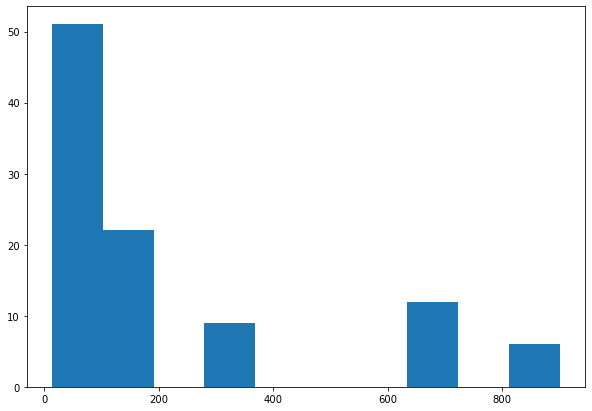

In [70]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(df_y_sp50['Train_Len'])
plt.show()

In [71]:
df_y_sp50['Test_Len'].value_counts()

7     53
14    23
28    12
21    12
Name: Test_Len, dtype: int64

So, a pretty clear winner in the test value.

Again, no clear winner for training, but clearly 7 days is the winner in testing. Let's do this one more time with the Nasdaq.

In [72]:
len(nsdq)

1701

In [73]:
nsdq.head()

Unnamed: 0 Symbol                   Company Name
0           1    AAL  American Airlines Group, Inc.
1           2   AAME  Atlantic American Corporation
2           3   AAOI  Applied Optoelectronics, Inc.
3           4   AAON                     AAON, Inc.
4           5   AAPL                     Apple Inc.

This dataframe is WAY too big to look through, so let's just do another 50, like we did with the S&P.

I had found a few stocks were missing from my NASDAQ list, so I've written the following code to get rid of all the symbols that had been delisted since I got this data. I've hashed it out since I saved the file, and don't need this code at the moment; but I may in the future, so I want to keep it around.

In [113]:
#no_data=[]
#for each in nsdq['Symbol']:
#    stock = yf.Ticker(each)
#    df1=stock.history(period='1d')
#    df=df1['Close']
#    if len(df)==0:
#        no_data.append(each)

- AAIT: No data found for this date range, symbol may be delisted
- AAVL: No data found for this date range, symbol may be delisted
- ABAC: No data found for this date range, symbol may be delisted
- ABAX: No data found for this date range, symbol may be delisted
- ABCD: No data found for this date range, symbol may be delisted
- ABCO: No data found for this date range, symbol may be delisted
- ABCW: No data found for this date range, symbol may be delisted
- ABDC: No data found, symbol may be delisted
- ABGB: No data found for this date range, symbol may be delisted
- ABTL: No data found for this date range, symbol may be delisted
- ABY: No data found for this date range, symbol may be delisted
- ACAS: No data found for this date range, symbol may be delisted
- ACAT: No data found for this date range, symbol may be delisted
- ACFC: No data found for this date range, symbol may be delisted
- ACHN: No data found, symbol may be delisted
- ACPW: No data found for this date range, symbol m

- BKYF: No data found for this date range, symbol may be delisted
- BLMT: No data found, symbol may be delisted
- BLVD: No data found for this date range, symbol may be delisted
- BLVDU: No data found for this date range, symbol may be delisted
- BLVDW: No data found, symbol may be delisted
- BNCL: No data found, symbol may be delisted
- BNCN: No data found for this date range, symbol may be delisted
- BOBE: No data found for this date range, symbol may be delisted
- BOFI: No data found for this date range, symbol may be delisted
- BONA: No data found for this date range, symbol may be delisted
- BONT: No data found for this date range, symbol may be delisted
- BOTA: No data found for this date range, symbol may be delisted
- BPFH: No data found for this date range, symbol may be delisted
- BPFHP: No data found, symbol may be delisted
- BPFHW: No data found, symbol may be delisted
- BRCD: No data found for this date range, symbol may be delisted
- BRCM: No data found for this date rang

- CPXX: No data found for this date range, symbol may be delisted
- CRAY: No data found, symbol may be delisted
- CRDC: No data found for this date range, symbol may be delisted
- CRDS: No data found for this date range, symbol may be delisted
- CRDT: No data found for this date range, symbol may be delisted
- CRME: No data found for this date range, symbol may be delisted
- CRRC: No data found for this date range, symbol may be delisted
- CRRS: No data found for this date range, symbol may be delisted
- CRTN: No data found for this date range, symbol may be delisted
- CRWN: No data found for this date range, symbol may be delisted
- CRZO: No data found, symbol may be delisted
- CSBK: No data found for this date range, symbol may be delisted
- CSCD: No data found for this date range, symbol may be delisted
- CSFL: No data found, symbol may be delisted
- CSRE: No data found for this date range, symbol may be delisted
- CSUN: No data found for this date range, symbol may be delisted
- CT

- FBSS: No data found, symbol may be delisted
- FCHI: No data found, symbol may be delisted
- FCLF: No data found for this date range, symbol may be delisted
- FCS: No data found for this date range, symbol may be delisted
- FCSC: No data found, symbol may be delisted
- FCTY: No data found for this date range, symbol may be delisted
- FCVA: No data found for this date range, symbol may be delisted
- FCZA: No data found for this date range, symbol may be delisted
- FCZAP: No data found, symbol may be delisted
- FDEF: No data found, symbol may be delisted
- FDML: No data found for this date range, symbol may be delisted
- FEIC: No data found for this date range, symbol may be delisted
- FES: No data found for this date range, symbol may be delisted
- FFBCW: No data found, symbol may be delisted
- FFKT: No data found for this date range, symbol may be delisted
- FFNM: No data found for this date range, symbol may be delisted
- FHCO: No data found for this date range, symbol may be deliste

- HWAY: No data found for this date range, symbol may be delisted
- HWCC: No data found for this date range, symbol may be delisted
- HYGS: No data found, symbol may be delisted
- HYND: No data found for this date range, symbol may be delisted
- IACI: No data found for this date range, symbol may be delisted
- IBCA: No data found for this date range, symbol may be delisted
- IBKC: No data found, symbol may be delisted
- ICEL: No data found for this date range, symbol may be delisted
- ICLDW: No data found, symbol may be delisted
- IDSA: No data found, symbol may be delisted
- IDSY: No data found, symbol may be delisted
- IDTI: No data found, symbol may be delisted
- IFAS: No data found for this date range, symbol may be delisted
- IFEU: No data found for this date range, symbol may be delisted
- IFNA: No data found, symbol may be delisted
- IFON: No data found for this date range, symbol may be delisted
- IGTE: No data found for this date range, symbol may be delisted
- IIJI: No data f

- MBLX: No data found for this date range, symbol may be delisted
- MBRG: No data found for this date range, symbol may be delisted
- MBTF: No data found, symbol may be delisted
- MBVT: No data found for this date range, symbol may be delisted
- MCEP: No data found, symbol may be delisted
- MCGC: No data found for this date range, symbol may be delisted
- MCOX: No data found for this date range, symbol may be delisted
- MCRL: No data found for this date range, symbol may be delisted
- MCUR: No data found for this date range, symbol may be delisted
- MDAS: No data found for this date range, symbol may be delisted
- MDCO: No data found, symbol may be delisted
- MDM: No data found for this date range, symbol may be delisted
- MDSO: No data found, symbol may be delisted
- MDSY: No data found for this date range, symbol may be delisted
- MDVN: No data found for this date range, symbol may be delisted
- MDVXU: No data found for this date range, symbol may be delisted
- MEET: No data found, s

- OXLCN: No data found, symbol may be delisted
- OXLCO: No data found for this date range, symbol may be delisted
- OZRK: No data found, symbol may be delisted
- PAGG: No data found for this date range, symbol may be delisted
- PARN: No data found for this date range, symbol may be delisted
- PATIV: No data found, symbol may be delisted
- PBCP: No data found for this date range, symbol may be delisted
- PBIB: No data found for this date range, symbol may be delisted
- PBMD: No data found for this date range, symbol may be delisted
- PBSK: No data found for this date range, symbol may be delisted
- PCBK: No data found for this date range, symbol may be delisted
- PCCC: No data found for this date range, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
- PCMI: No data found, symbol may be delisted
- PCO: No data found for this date range, symbol may be delisted
- PCYC: No data found for this date range, symbol may be delisted
- PDII: No data found 

- SAEX: No data found, symbol may be delisted
- SAJA: No data found for this date range, symbol may be delisted
- SALE: No data found for this date range, symbol may be delisted
- SANWZ: No data found, symbol may be delisted
- SAPE: No data found for this date range, symbol may be delisted
- SBBX: No data found, symbol may be delisted
- SBCP: No data found for this date range, symbol may be delisted
- SBLKL: No data found, symbol may be delisted
- SBNYW: No data found, symbol may be delisted
- SBRAP: No data found, symbol may be delisted
- SBSA: No data found for this date range, symbol may be delisted
- SCAI: No data found for this date range, symbol may be delisted
- SCLN: No data found for this date range, symbol may be delisted
- SCMP: No data found for this date range, symbol may be delisted
- SCOK: No data found for this date range, symbol may be delisted
- SCSS: No data found for this date range, symbol may be delisted
- SEMI: No data found for this date range, symbol may be del

- TKMR: No data found, symbol may be delisted
- TLF: No data found, symbol may be delisted
- TLMR: No data found for this date range, symbol may be delisted
- TNAV: No data found, symbol may be delisted
- TNGO: No data found for this date range, symbol may be delisted
- TRAK: No data found for this date range, symbol may be delisted
- TRCB: No data found, symbol may be delisted
- TRCH: No data found for this date range, symbol may be delisted
- TRGT: No data found for this date range, symbol may be delisted
- TRIV: No data found for this date range, symbol may be delisted
- TROV: No data found, symbol may be delisted
- TROVU: No data found, symbol may be delisted
- TROVW: No data found, symbol may be delisted
- TRTL: No data found for this date range, symbol may be delisted
- TRTLU: No data found for this date range, symbol may be delisted
- TRTLW: No data found, symbol may be delisted
- TSRA: No data found for this date range, symbol may be delisted
- TSRE: No data found for this date

- ZIONW: No data found, symbol may be delisted
- ZIONZ: No data found, symbol may be delisted
- ZIV: No data found for this date range, symbol may be delisted
- ZLTQ: No data found for this date range, symbol may be delisted
- ZN: No data found, symbol may be delisted
- ZSPH: No data found, symbol may be delisted
- ZU: No data found, symbol may be delisted


In [114]:
#len(no_data)

1265

In [115]:
#no_data[4:8]

['ABCD', 'ABCO', 'ABCW', 'ABDC']

In [116]:
#y=nsdq.loc[nsdq['Symbol']==no_data[4]].index

In [117]:
#y[0]

12

So here's this loop will create a list of index numbers for all the delisted/bad stock symbols

In [118]:
#nd_index=[]
#for each in no_data:
#    y=nsdq.loc[nsdq['Symbol']==each].index
#    nd_index.append(y[0])

In [119]:
#len(nd_index)

1265

In [120]:
#nsdq = nsdq.drop(labels=nd_index, axis=0)

In [74]:
nsdq.reset_index(drop=True,inplace=True)

Like I mentioned above, saving it so it saves time running this notebook, and it's readily useable.

In [127]:
#nsdq.to_csv('Data/nasdaq.csv',index=True)

Just to be safe, let's do the same thing with the S&P data.

In [79]:
no_data_sp=[]
for each in sp_500['Symbol']:
    stock = yf.Ticker(each)
    df1=stock.history(period='1d')
    df=df1['Close']
    if len(df)==0:
        no_data_sp.append(each)

In [80]:
no_data_sp

[]

In [ ]:
#sp_500.loc[sp_500['Symbol']==no_data_sp[1]].index

In [ ]:
#sp_500.loc[sp_500['Symbol']==no_data_sp[0]].index

In [ ]:
#sp_500.loc[sp_500['Symbol']==no_data_sp[2]].index

In [79]:
#sp_500 = sp_500.drop(labels=[18,64,78], axis=0)

In [80]:
#sp_500.to_csv('Data/constituents_csv.csv',index=True)

In [82]:
#sp_500.reset_index(drop=True,inplace=True)

In [75]:
sp_500.head()

Unnamed: 0 Symbol                 Name                  Sector
0           0    MMM                   3M             Industrials
1           1    ABT  Abbott Laboratories             Health Care
2           2   ABBV               AbbVie             Health Care
3           3   ABMD              Abiomed             Health Care
4           4    ACN            Accenture  Information Technology

We'll make another list of random numbers for us to test.

In [85]:
picks=[]
for i in range (0,25):
    x = random.randint(0,(len(nsdq)-1))
    picks.append(x)

In [86]:
nsdq.head()

Symbol                   Company Name
0    AAL  American Airlines Group, Inc.
1   AAME  Atlantic American Corporation
2   AAOI  Applied Optoelectronics, Inc.
3   AAON                     AAON, Inc.
4   AAPL                     Apple Inc.

In [87]:
nsdq.drop(columns='Unnamed: 0',inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [88]:
len(nsdq)

1701

In [89]:
cols2=['Symbol','Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in nsdq['Symbol'][picks]:
    stock_res_nd50 = tt_test(each,trains,tests)
    print (stock_res_nd50[(stock_res_nd50.MAE == stock_res_nd50.MAE.min())])
for each in stock_res_nd50.index:
    stock_res_nd50['Symbol'][each]=str(stock_res_nd50['Symbol'][each])
    stock_res_nd50['Symbol'][each]=stock_res_nd50['Symbol'][each].replace('>','')
    stock_res_nd50['Symbol'][each]=stock_res_nd50['Symbol'][each].split('<', 1)[-1]
df_x=pd.DataFrame(columns=stock_res_nd50.columns)
df_y_nd50=pd.DataFrame(columns=stock_res_nd50.columns)

Processing:  yfinance.Ticker object <MIDD>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.823, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.154, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=72.086, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.291 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=146.377, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=147.220, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=147.242, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=145.712, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=149.178, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1895.997, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1898.172, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1900.153, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1900.158, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1897.184, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1895.635, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1893.635, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1895.635, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1900.154, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1897.409, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1892.466, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1899.179, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1894.413, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1894.466, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1897.246, Time=0.09 sec
 ARIMA(1,1

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3481.995, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3477.928, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3489.596, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3479.801, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3479.588, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3485.431, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3480.337, Time=0.16 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 2.002 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4340.955, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4344.481, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4346.478, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4346.479, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4342.812, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4340.863, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12.850, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12.411, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=120.910, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=11.041, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=13.320, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=13.343, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=15.046, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.916 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15.313, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.756, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16.550, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15.994, Time=0

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=622.296, Time=0.36 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=624.263, Time=0.62 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 10.814 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=830.468, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=825.805, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=827.406, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=827.446, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=823.827, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=828.895, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.460 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.980, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.841, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.807, Tim

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=824.235, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.159 seconds
                           Symbol Train_Len Test_Len       Exp_var       MAE  \
29  yfinance.Ticker object <FUNC>        30        7 -2.220446e-16  0.094286   
30  yfinance.Ticker object <FUNC>        60        7 -2.220446e-16  0.094286   
31  yfinance.Ticker object <FUNC>       180        7 -2.220446e-16  0.094286   
32  yfinance.Ticker object <FUNC>       360        7 -2.220446e-16  0.094286   
33  yfinance.Ticker object <FUNC>       720        7 -2.220446e-16  0.094286   
34  yfinance.Ticker object <FUNC>       900        7 -2.220446e-16  0.094286   

        RMSE        R2  
29  0.128508 -0.004468  
30  0.128508 -0.004468  
31  0.128508 -0.004468  
32  0.128508 -0.004468  
33  0.128508 -0.004468  
34  0.128508 -0.004468  
Processing:  yfinance.Ticker object <GLBS>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19.070, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.346, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20.404, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17.334, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22.325, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.295 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=9.043, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=90.275, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=11.631, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=53.791, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=352.421, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=13.550, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=14.311, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=11.513, T

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.825 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=307.141, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=308.475, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=309.274, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=308.979, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=308.249, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=311.608, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=311.098, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=310.605, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=310.572, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=311.395, 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=334.577, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=334.560, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=327.919, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=327.573, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=337.421, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=331.377, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=334.761, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=328.459, Time=0.54 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=324.444, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=333.702, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=333.657, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=326.647, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=326.311, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=336.495, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=329.988, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]  

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1093.203, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1107.397, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1103.585, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1104.912, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1105.638, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1095.205, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1099.228, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1080.938, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1098.915, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1077.980, Time=0.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1075.985, Time=0.20 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1089.789, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1082.418, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1098.490, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept

 ARIMA(3,1,3)(0,0,0)[0]             : AIC=439.448, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=458.805, Time=0.05 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=439.274, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=444.206, Time=0.08 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=440.165, Time=0.13 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 2.694 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1092.522, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1106.953, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1103.110, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1104.457, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1105.224, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1094.416, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1098.561, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1080.217, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] int

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=450.078, Time=0.12 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=444.341, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=440.010, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=448.296, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=453.232, Time=0.04 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=449.008, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=441.976, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=459.953, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=441.073, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=448.085, Time=0.08 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=442.350, Time=0.20 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 2.708 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1092.581, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1107.166, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=107.446, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=131.596, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=630.172, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=107.348, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=108.056, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=108.315, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=107.898, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=110.060, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.950 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=456.354, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=467.428, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=469.426, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=469.426, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : A

Processing:  yfinance.Ticker object <MBSD>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-46.491, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-57.936, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-56.056, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-56.062, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=130.244, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-54.160, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.327 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-113.754, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-106.394, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-118.513, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-113.069, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=276.756, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-117.877, Time=0.03 sec
 ARIMA(1,

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-235.378, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-233.356, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-239.196, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-238.686, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-237.213, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-238.821, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-235.196, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.804 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-745.428, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-732.568, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-738.050, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-740.734, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-734.566, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-747.452, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-763.326, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-763.323, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-760.291, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-756.235, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-761.342, Time=0.14 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.812 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1200.439, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1185.972, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1187.772, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1189.956, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1187.023, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1198.167, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1198.701, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1194.745, Time=0.29 sec
 ARIMA(2,1,3)(

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2574.114, Time=0.73 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2575.739, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2592.142, Time=1.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2577.164, Time=0.30 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-2590.494, Time=1.90 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-2592.186, Time=1.52 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-2575.200, Time=0.45 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-2590.888, Time=1.53 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=-2593.260, Time=2.00 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=-2575.300, Time=1.23 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=-2589.079, Time=2.30 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=-2585.888, Time=0.95 sec

Best model:  ARIMA(2,1,5)(0,0,0)[0] intercept
Total fit time: 15.723 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3227.236, Time=1.21 sec
 ARIMA(0

 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-1933.684, Time=0.21 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-1934.024, Time=0.26 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-1683.159, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-1933.033, Time=0.39 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-1933.352, Time=0.37 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-1719.891, Time=0.05 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-1930.060, Time=0.55 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-1932.955, Time=0.84 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 3.261 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1.421, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-0.932, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6.919, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4.775, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=78.335, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] 

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-321.810, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-247.283, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-267.923, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-317.424, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-322.875, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-324.674, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-323.148, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-324.505, Time=0.11 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-324.014, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 1.064 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-824.712, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-650.785, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-707.738, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]    

 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-1601.177, Time=0.32 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-1602.378, Time=0.22 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-1601.136, Time=0.41 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-1599.188, Time=0.43 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-1601.052, Time=0.45 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 2.650 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-2050.680, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-1487.475, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-1701.214, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-2054.776, Time=0.14 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-2054.388, Time=0.22 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-2054.494, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-2053.271, Time=0.45 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-2053.486, Time=0.37 sec

Best mod

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=340.226, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=336.639, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=337.272, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=337.196, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=334.639, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=338.055, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.387 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=679.384, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=674.417, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=673.735, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=673.800, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=672.645, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=675.643, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.417 seconds
Performing stepwise sea

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=19.233, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=17.589, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=121.549, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=18.806, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=18.809, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=20.513, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.499 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29.580, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31.443, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31.354, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.522, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30.663, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3011.069, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3012.169, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3012.194, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3010.563, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.924 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=49.244, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48.799, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=49.556, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=166.698, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=51.106, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=50.515, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=52.539

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2467.834, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2463.540, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2464.875, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2464.901, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2462.828, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2466.659, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.831 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2988.502, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2989.904, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2989.918, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2988.612, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fi

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16.104, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.884, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.673, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.722, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.928, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.806, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.296, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-14.150, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-14.154, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6.270, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.415, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6.877, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-12.158, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-15.597, Time=0.08 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.688 seconds
Performing stepwise search to 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.766, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1.099, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5.790, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-11.936, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-15.548, Time=0.09 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.831 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-20.408, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.498, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.001, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.262, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.113, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10.740, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8.294, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-18.425, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-21.764

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5.673, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-12.809, Time=0.43 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-16.478, Time=0.11 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.789 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-15.229, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.000, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.366, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.642, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.669, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6.485, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4.200, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-13.320, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-16.804, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6.733, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-16.36

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-11.540, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-15.313, Time=0.09 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.696 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2.816, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.325, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.178, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13.275, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.751, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.606, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.908, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4.084, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2.097, Time=0.32 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-2.262, Time=0.60 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-3.686, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4.968

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=392.036, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=391.879, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=393.811, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=388.545, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=390.050, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=389.894, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=388.902, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=391.825, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.025 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=478.045, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=480.094, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=474.574, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=475.171, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=478.178, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept  

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12.903, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=17.523, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.755 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24.879, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30.332, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.473, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23.403, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28.699, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22.901, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23.924, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24.319, Time=0.11 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=462.583, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=470.252, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=464.445, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=465.195, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=468.258, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=465.346, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=465.867, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=455.821, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=460.422, Time=0.37 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=450.737, Time=0.51 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=450.924, Time=0.39 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=452.457, Time=0.88 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=451.438, Time=1.07 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=457.814, Time=0.99 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=450.8

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2751.873, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2752.300, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2750.016, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2750.566, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2750.638, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2748.467, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2750.228, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2750.052, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2750.304, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2752.232, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2746.814, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2748.406, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2748.564, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2748.367, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2748.686, Time=0.06 sec
 ARIMA(3,1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3355.310, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3356.922, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3354.045, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3354.585, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3355.222, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3353.102, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3353.458, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3353.409, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3354.833, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3355.463, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3351.414, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3352.396, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3351.742, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3351.676, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3353.175, Time=0.16 sec
 ARIMA(3,1

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3355.295, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=3355.351, Time=0.05 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=3353.054, Time=0.45 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 5.706 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=58.248, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=54.185, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=52.437, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=52.711, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=160.507, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=54.555, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=54.412, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=56.396, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.511 seconds
Performing stepwise search to m

Processing:  yfinance.Ticker object <VIVO>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=61.424, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=64.329, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=55.486, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=59.621, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=125.857, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=57.484, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=57.484, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=59.485, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.448 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=93.882, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=115.693, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=90.477, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] int

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=23.982, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=25.817, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=31.783, Time=0.05 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.054 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=51.028, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.237, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52.174, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52.184, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.160, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=53.876, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.345 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=53.649, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=53.662, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=152.952, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=55.472, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.341 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=74.000, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=67.835, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=70.261, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=72.160, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=68.920, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=69.216, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=70.751, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=65.852, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=67.159, 

 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-61.298, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-64.552, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-63.691, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-64.028, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-52.160, Time=0.06 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.105 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-95.854, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.360, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-95.852, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.680, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.428 seconds
Performing stepwise search to minim

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-37.698, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.631 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-98.008, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-22.901, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-103.803, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-62.418, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=293.968, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-101.944, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-101.942, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-99.944, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.618 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-303.519

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-104.970, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.541 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-316.230, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-317.169, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-315.622, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-315.696, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-318.596, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-314.005, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.600 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-595.592, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-600.502, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-599.154, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : A

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=570.818, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=569.677, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=569.916, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=570.214, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=567.975, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=570.331, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.456 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1480.548, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1475.481, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1475.179, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1475.239, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1474.646, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1476.762, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Tota

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=581.842, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=670.188, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=583.842, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=649.524, Time=0.03 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=583.578, Time=0.24 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 1.586 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1481.897, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1476.756, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1476.496, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1476.553, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1475.764, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1478.129, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=678.095, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.662 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1137.348, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1137.665, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1139.275, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1139.272, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1135.692, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1139.966, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.911 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1486.004, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1492.395, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1494.194, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1494.199, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]            

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=696.209, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=696.246, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=698.039, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=698.033, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=694.380, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=696.702, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.609 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1129.466, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1129.906, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1131.447, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1131.443, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1127.909, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1131.843, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.954 seconds
Performing stepwi

 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 1.136 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=147.023, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=140.707, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=142.246, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=142.292, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=138.999, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=144.216, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.213 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=398.714, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=391.724, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=392.887, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=392.912, Ti

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=995.053, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=993.059, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=995.055, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=997.296, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=997.058, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=991.065, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=998.037, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=993.059, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=993.061, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=995.304, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=995.064, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.929 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1825.266, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1837.447, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1823.447, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1824.462, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1825.251, Time=0.23 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.997 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2300.702, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2316.185, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2301.334, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2303.666, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2314.191, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2298.736, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2297.761, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2298.701, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2301.259, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2300.705, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.601 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.576, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.437, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=74.370, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.419, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.364 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=118.366, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=120.364, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=120.364, Time=0.02 sec
 ARI

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=100.312, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=102.215, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=102.213, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=99.408, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=104.213, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.427 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=377.437, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=379.435, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=379.435, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=375.794, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=381.435, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.610 seconds
Performing stepwise search to mi

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1032.769, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1061.577, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1062.463, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1061.975, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1059.593, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1050.650, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1029.811, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1043.005, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1027.260, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1037.543, Time=0.25 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1040.650, Time=0.70 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1027.584, Time=0.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1029.916, Time=0.43 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : 

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1775.446, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1744.701, Time=0.71 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1768.952, Time=0.17 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1743.946, Time=0.43 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1767.210, Time=0.48 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1745.165, Time=0.63 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1746.030, Time=0.69 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1746.378, Time=1.04 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1762.230, Time=0.22 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1747.269, Time=1.22 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1742.840, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1743.514, Time=0.47 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1766.196, Time=0.26 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1743.992, Time=0.32 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1744.861, Time=0.39 sec
 ARIMA(3,1

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-125.018, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-123.041, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-123.592, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-121.709, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-126.698, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-119.094, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-124.716, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-124.717, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-125.235, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-123.384, Time=0.30 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.456 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16.898, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=17.014, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] interce

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.141, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.932, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18.189, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14.238, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13.686, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=15.670, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=12.723, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=12.850, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=14.646, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=14.632, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=13.285, Time=

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.623, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=68.497, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.239, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=65.495, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=67.248, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=66.985, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=65.813, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=66.436, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=67.319, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.747 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=61.532, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=59.823, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.274, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=59.850, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=57.907

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4621.869, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.679 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.936, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.920, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=60.918, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59.717, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=62.914, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.239 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=144.282, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=172.866, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=144.691, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=154.224, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=389.502, Ti

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=69.241, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=71.111, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=73.592, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=73.306, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.102 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=150.782, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=145.488, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=147.124, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=147.096, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=145.647, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.187 seconds
Performing stepwise search to minimize 

 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-223.841, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-237.628, Time=0.30 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-237.680, Time=0.41 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-212.611, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-221.386, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-230.769, Time=0.09 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=-236.169, Time=0.30 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 6.917 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-411.871, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-391.461, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-408.000, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-406.842, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-393.455, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-409.098, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=-242.478, Time=0.32 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 7.812 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-414.931, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-394.201, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-410.699, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-409.439, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-396.185, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-412.380, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-411.822, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-441.102, Time=0.56 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-434.372, Time=0.68 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-460.969, Time=1.30 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-462.720, Time=0.64 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-444.174, Time=0.19 sec
 ARIMA(5,1,1)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-416.514, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-395.462, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-412.097, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-410.811, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-397.453, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-413.866, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-413.288, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-442.909, Time=0.76 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-436.184, Time=0.36 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-462.757, Time=1.03 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-464.579, Time=0.64 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-446.267, Time=0.23 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-462.729, Time=0.84 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-430.898, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-454.041, Time=0.29 sec
 ARIMA(5,1

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-411.905, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-411.295, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-440.472, Time=0.62 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-433.921, Time=0.41 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-460.826, Time=1.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-462.522, Time=0.66 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-443.770, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-460.776, Time=0.76 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-428.825, Time=0.24 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-452.066, Time=0.27 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-459.053, Time=0.78 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-464.400, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-435.803, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-445.642, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-462.659, Time=0.32 sec
 ARIMA(4,1

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-30.637, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.886, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-29.644, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.265 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.402, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.649, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-35.473, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.238, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-34.191, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-34.019, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-32.192, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-37.098, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-35.665, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : A

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.056, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8.896, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.917, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-6.911, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6.947, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4.899, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.138 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-311.468, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-275.943, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-312.673, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-316.793, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-277.908, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-315.082, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-315.074, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-548.317, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-553.890, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-552.391, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-552.332, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-548.770, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-550.312, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.037 seconds
                            Symbol Train_Len Test_Len   Exp_var      MAE  \
117  yfinance.Ticker object <MBSD>       720        7  0.613115  0.00939   

         RMSE        R2  
117  0.010066  0.442078  
Processing:  yfinance.Ticker object <MDIV>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.917, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11.141, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf

 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.202 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-106.096, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-104.151, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-104.179, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-107.255, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.431 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-273.865, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-272.114, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-272.176, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-270.189, Ti

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-54.330, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-55.016, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.834 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-110.853, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-109.017, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-109.111, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-111.571, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.468 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-272.584, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-273.915, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-272.145,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.388 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-267.835, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-269.812, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-267.952, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-267.990, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-265.432, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-268.689, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.535 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16.027, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.756, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.196, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22.293, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18.76

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1609.503, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1607.654, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1609.650, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1609.649, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1609.015, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.682 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2783.375, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2785.358, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2787.356, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2787.355, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2786.162, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2786.715, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2786.626, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] int

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=207.163, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=152.893, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=180.472, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=376.822, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=153.648, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=153.615, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=154.319, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.628 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=283.259, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=283.715, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=283.822, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=281.836, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=889.903, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=887.990, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=888.083, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=885.147, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=888.182, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=888.239, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=889.908, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=889.987, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=888.007, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=888.033, Time=0.01 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 0.867 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1598.268, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1594.388, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   :

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-588.028, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-587.184, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-593.486, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-594.999, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-600.971, Time=0.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-594.342, Time=0.32 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-605.407, Time=1.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-593.364, Time=0.65 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-603.466, Time=1.61 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-599.004, Time=1.33 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-596.651, Time=0.44 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-588.964, Time=1.57 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-607.370, Time=0.60 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-602.940, Time=0.46 sec
 ARIMA(4,1,1)(0

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-587.965, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-587.212, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-593.294, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-594.803, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-600.730, Time=0.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-594.129, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-605.109, Time=0.98 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-593.062, Time=0.47 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-603.168, Time=1.37 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-598.779, Time=1.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-596.328, Time=0.47 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-607.100, Time=0.59 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-602.723, Time=0.49 sec
 ARIMA(4,1,1)(0,0,0)

 ARIMA(5,1,3)(0,0,0)[0]             : AIC=-218.048, Time=0.41 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 7.911 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-601.131, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-586.075, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-587.925, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-588.930, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-588.065, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-594.300, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-595.818, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-601.594, Time=0.99 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-595.109, Time=0.31 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-606.016, Time=1.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-594.079, Time=0.55 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-604.081, Time=1.27 sec
 ARIMA(4,1,3)(0,0,0)[0

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-212.965, Time=0.27 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-216.250, Time=0.58 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-222.022, Time=0.38 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-217.636, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-212.065, Time=0.15 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=-220.054, Time=0.33 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=-220.055, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-213.145, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-214.922, Time=0.27 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-214.800, Time=0.30 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=-218.055, Time=0.42 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 7.990 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-601.161, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-586.210, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [90]:
a=0
b=len(stock_res_nd50)
c=int(b/len(picks))
while a<=(b-c):
    df_x=stock_res_nd50.loc[stock_res_nd50.index[a:(a+c)]]
    df_ph=df_x.sort_values(by=['MAE']).head(2)
    df_y_nd50=pd.concat([df_y_nd50,df_ph])
    a+=c

In [91]:
stock_res_nd50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 699
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Symbol     700 non-null    object 
 1   Train_Len  700 non-null    object 
 2   Test_Len   700 non-null    object 
 3   Exp_var    700 non-null    float64
 4   MAE        700 non-null    float64
 5   RMSE       700 non-null    float64
 6   R2         700 non-null    float64
dtypes: float64(4), object(3)
memory usage: 63.8+ KB


In [92]:
df_y_nd50['Test_Len'].value_counts()

7     33
28     7
14     5
21     5
Name: Test_Len, dtype: int64

In [93]:
df_y_nd50['Train_Len'].value_counts()

14     9
60     9
360    9
180    8
30     6
720    5
900    4
Name: Train_Len, dtype: int64

Still no clear winner in the training length. But test length is definitely going to be 7 days. What if there is some correlation between the test length and training length? Let's run through these indices again, but this time with just 7 days as our test length.

In [94]:
tests=[7]

In [95]:
cols2=['Symbol','Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in dow_30['Symbol']:
    stock_res_d30 = tt_test(each,trains,tests)
    print (stock_res_d30[(stock_res_d30.MAE == stock_res_d30.MAE.min())])
for each in stock_res_d30.index:
    stock_res_d30['Symbol'][each]=str(stock_res_d30['Symbol'][each])
    stock_res_d30['Symbol'][each]=stock_res_d30['Symbol'][each].replace('>','')
    stock_res_d30['Symbol'][each]=stock_res_d30['Symbol'][each].split('<', 1)[-1]
df_x=pd.DataFrame(columns=stock_res_d30.columns)
df_y_d30=df_x.sort_values(by=['MAE']).head(3)

Processing:  yfinance.Ticker object <MMM>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=64.048, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=57.284, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=59.127, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=59.088, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=190.069, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=61.066, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.251 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=139.404, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=158.962, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=133.698, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=145.659, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=404.588, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=135.804, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1895.674, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1890.097, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1899.392, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1897.354, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1899.320, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1897.867, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1900.031, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1899.886, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1893.908, Time=0.46 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 5.212 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3390.786, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3407.580, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3403.981, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] int

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3920.141, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3919.329, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3921.297, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3921.282, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3921.124, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3917.785, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3918.763, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3917.814, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3919.746, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3919.729, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3919.573, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3918.587, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3918.645, Time=0.27 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.334 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=309.305, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=309.469, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=309.325, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=307.856, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=311.321, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.282 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=960.141, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=956.972, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=957.319, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=957.505, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=956.127, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=958.959, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.408 seconds
Performing stepwise search 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1675.271, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1702.614, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1695.551, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1697.512, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1700.618, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1691.812, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1693.182, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1673.648, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1694.720, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1674.863, Time=0.41 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1673.507, Time=0.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1673.122, Time=0.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1692.607, Time=0.16 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1674.402, Time=0.34 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1752.616, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1776.544, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1761.899, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1762.744, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1774.785, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1765.712, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1765.716, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1763.723, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1767.699, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1767.716, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1771.681, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1750.891, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1764.026, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.781 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=899.144, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=902.858, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=903.901, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=903.413, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=903.149, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=902.395, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=902.179, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=896.435, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=901.659, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=898.403, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=897.683, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=129.691, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=173.278, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=125.647, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=143.008, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=656.225, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=126.952, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=127.140, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=128.730, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.829 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=583.466, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=582.281, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=582.610, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=582.407, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1692.576, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1719.729, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1714.369, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1715.207, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1717.729, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1715.581, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1716.981, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1694.256, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1694.269, Time=0.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1715.227, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1718.046, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1718.658, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1690.576, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1713.581, Time=0.06 sec
 ARIMA(2,1,1)(0

 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1593.367, Time=0.30 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1592.483, Time=0.20 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1596.079, Time=0.08 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1594.019, Time=0.26 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1597.840, Time=0.08 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=1595.366, Time=0.60 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1591.008, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=1594.664, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1595.862, Time=0.12 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1591.990, Time=0.19 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=1592.584, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1596.418, Time=0.03 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=1596.457, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1595.145, Time=0.23 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=1593.990, Time=0.48 sec

Best mode

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1796.947, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1798.812, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1780.298, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1800.036, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1780.596, Time=0.36 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1798.568, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1780.027, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1790.327, Time=0.19 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1782.006, Time=0.42 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1782.377, Time=0.26 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1783.644, Time=0.65 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1778.233, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1788.499, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1792.777, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1780.225, Time=0.52 sec
 ARIMA(2,1

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1954.422, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1958.202, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1934.588, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1937.649, Time=0.17 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1935.832, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1944.242, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1939.469, Time=0.30 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1942.699, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1932.806, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1951.431, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1935.825, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1938.918, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1934.010, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1956.362, Time=0.05 sec
 ARIMA(2,1,3)(0

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=1129.666, Time=0.35 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=1127.674, Time=0.20 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=1141.177, Time=0.18 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=inf, Time=1.15 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1139.469, Time=0.24 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=inf, Time=0.58 sec

Best model:  ARIMA(2,1,5)(0,0,0)[0]          
Total fit time: 9.791 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2089.482, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2159.505, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2134.676, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2139.272, 

Processing:  yfinance.Ticker object <NKE>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=46.685, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=49.208, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=47.162, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=183.896, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=46.269, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=44.128, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=46.307, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=56.628, Time=0.05 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.817 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=173.635, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4238.073, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4238.069, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4221.293, Time=0.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4221.100, Time=0.87 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4240.071, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4238.046, Time=0.92 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4234.005, Time=0.43 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4219.627, Time=0.59 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4238.604, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4219.836, Time=0.50 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.46 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=4236.546, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4236.605, Time=0.11 sec
 ARIMA(1,1,4)(0,0,0)[0]  

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=51.313, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=78.877, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=45.788, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=63.265, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=327.447, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=47.682, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=47.710, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=49.568, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.795 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.979, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.591, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=65.481, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.137, Tim

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=204.605, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=213.530, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=200.766, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=201.409, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=441.821, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=200.723, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=202.824, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=202.638, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=200.675, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=202.616, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=200.790, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=213.613, Time=0.03 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.811 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=388.488, Time=0

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=979.605, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=978.705, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=981.132, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.248 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2192.963, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2208.544, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2199.477, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2202.372, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2207.387, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2191.740, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2190.455, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2191.505, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2196.968, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2193.343, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]  

 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2698.232, Time=0.83 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=2694.347, Time=1.82 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=2693.995, Time=1.19 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=2702.732, Time=0.55 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=2694.603, Time=0.97 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=2699.323, Time=1.00 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=2696.991, Time=1.00 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=2695.943, Time=0.59 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0] intercept
Total fit time: 12.143 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3269.257, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3289.674, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3271.717, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3271.903, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3289.204, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3208.902, Time=0.18 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=3208.808, Time=0.28 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3229.074, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3209.906, Time=0.25 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=3216.155, Time=0.06 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=3210.597, Time=0.36 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 5.259 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3928.697, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3969.873, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3949.354, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3954.166, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3968.057, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3934.296, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3937.858, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4219.042, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4225.783, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4214.085, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4214.059, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4224.641, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4216.014, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4216.010, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4217.091, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4213.192, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4215.132, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4215.125, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4213.185, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4215.126, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4206.286, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]          

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5477.738, Time=0.82 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5512.182, Time=0.37 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5496.437, Time=0.61 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5481.603, Time=0.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5512.250, Time=1.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5492.246, Time=0.54 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5472.790, Time=1.13 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=5474.760, Time=1.50 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=5473.741, Time=1.63 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=5473.104, Time=0.93 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=5490.169, Time=1.03 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=5473.629, Time=2.01 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=5475.057, Time=0.62 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0] intercept
Total fit time: 14.541 seconds
                          Symbol Train_Len Test_Len   Exp_var   

Processing:  yfinance.Ticker object <V>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=86.294, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=82.408, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=76.780, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=78.590, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=195.342, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=78.327, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=78.438, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=80.422, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.516 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=142.246, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=143.932, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercep

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=505.806, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=506.772, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=506.920, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=504.628, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=508.325, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.499 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1141.980, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1141.056, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1140.820, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1141.039, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1139.069, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1144.742, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.497 seconds
Performing stepwise s

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [96]:
stock_res_d30.head(14)

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
0     MMM        14        7 -2.220446e-16  1.294898  1.410027 -0.115012
1     MMM        30        7  1.763104e-01  1.186575  1.263835  0.104211
2     MMM        60        7  1.585954e-01  1.241890  1.387447 -0.079586
3     MMM       180        7 -5.650815e-01  2.040663  2.517961 -2.555681
4     MMM       360        7  2.932009e-02  1.437196  1.729886 -0.678262
5     MMM       720        7  0.000000e+00  1.585715  1.883669 -0.989911
6     MMM       900        7  0.000000e+00  1.585715  1.883669 -0.989911
7     AXP        14        7 -1.663761e-01  1.599672  2.028419 -2.050242
8     AXP        30        7  0.000000e+00  1.119999  1.397444 -0.447730
9     AXP        60        7  0.000000e+00  1.119999  1.397444 -0.447730
10    AXP       180        7 -1.174492e+00  2.563882  3.083289 -6.047702
11    AXP       360        7  1.558403e-01  1.244329  1.590622 -0.875656
12    AXP       720        7  1.480193e-01  1.147821  1.435927 -0.528565
13    AXP       900        7  1.264457e-01  1.344594  1.692652 -1.124000

In [97]:
len(stock_res_d30)

210

In [98]:
df_y_d30=pd.DataFrame(columns=stock_res_d30.columns)

In [99]:
a=0
b=len(stock_res_d30)
while a<=(b-7):
    df_x=stock_res_d30.loc[stock_res_d30.index[a:(a+7)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_d30=pd.concat([df_y_d30,df_ph])
    a+=7

In [100]:
df_y_d30

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
1      MMM        30        7  1.763104e-01  1.186575  1.263835  0.104211
2      MMM        60        7  1.585954e-01  1.241890  1.387447 -0.079586
0      MMM        14        7 -2.220446e-16  1.294898  1.410027 -0.115012
8      AXP        30        7  0.000000e+00  1.119999  1.397444 -0.447730
9      AXP        60        7  0.000000e+00  1.119999  1.397444 -0.447730
..     ...       ...      ...           ...       ...       ...       ...
197    WBA        30        7  2.220446e-16  0.334287  0.372599 -0.738652
198    WBA        60        7  2.220446e-16  0.334287  0.372599 -0.738652
207    WMT       360        7 -3.139313e-02  0.984366  1.076122 -4.729643
208    WMT       720        7 -2.465103e-02  0.991896  1.086535 -4.841061
209    WMT       900        7 -2.034044e-02  0.997460  1.094168 -4.923422

[90 rows x 7 columns]

In [101]:
df_y_d30['Train_Len'].value_counts()

720    19
900    14
30     12
60     12
360    12
14     11
180    10
Name: Train_Len, dtype: int64

Again, unfortunately there is no clear leader in training length. Let's try again with the S&P

In [102]:
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in sp_500['Symbol'][picks_sp50]:
    stock_res_sp50 = tt_test(each,trains,tests)
    print (stock_res_sp50[(stock_res_sp50.MAE == stock_res_sp50.MAE.min())])
for each in stock_res_sp50.index:
    stock_res_sp50['Symbol'][each]=str(stock_res_sp50['Symbol'][each])
    stock_res_sp50['Symbol'][each]=stock_res_sp50['Symbol'][each].replace('>','')
    stock_res_sp50['Symbol'][each]=stock_res_sp50['Symbol'][each].split('<', 1)[-1]
df_x_sp50=pd.DataFrame(columns=stock_res_sp50.columns)
df_y_sp50=df_x_sp50.sort_values(by=['MAE']).head(3)

Processing:  yfinance.Ticker object <SYY>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.375, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46.375, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46.374, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.096, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.318 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=93.751, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=95.685, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=95.642, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=92.608, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]   

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1419.640, Time=0.26 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1400.659, Time=0.67 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1419.510, Time=0.25 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=1386.105, Time=0.64 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=1393.350, Time=0.41 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=1399.203, Time=1.17 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=1400.207, Time=0.11 sec

Best model:  ARIMA(5,0,1)(0,0,0)[0] intercept
Total fit time: 8.445 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2443.413, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2470.532, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2453.340, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2454.752, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2468.626, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2454.983, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4332.968, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4330.715, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4332.696, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4332.689, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4333.073, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4330.797, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.397 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5387.138, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5389.574, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5386.420, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5386.431, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5388.927, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5388.407, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5386.491, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1861.345, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1858.503, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1859.347, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1860.513, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1815.497, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1857.621, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1858.236, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1861.213, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1861.160, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1858.432, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1859.169, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1839.325, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1818.225, Time=0.71 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.721 seconds
    

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3177.060, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3178.762, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3178.785, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3175.941, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3179.710, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.218 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3841.553, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3836.724, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3838.586, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3838.595, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3836.031, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3839.606, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.185 seconds
                

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=223.897, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=224.496, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=225.869, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.397 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=439.070, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=440.665, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=440.650, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=439.179, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=442.650, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.328 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1396.874, Time=

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1261.019, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1257.434, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1265.883, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1266.231, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1259.145, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1269.172, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1270.218, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1267.328, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1259.496, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1259.107, Time=0.14 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 1.740 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2280.037, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2312.412, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2299.086, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0

ConnectionError: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v8/finance/chart/CSCO?range=5y&interval=1d&includePrePost=False&events=div%2Csplits (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000222F8830D30>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))

In [103]:
len(stock_res_sp50)

63

In [106]:
c=int((len(stock_res_sp50))/(len(picks_sp50)))

In [107]:
a=0
b=len(stock_res_sp50)
while a<=(b-c):
    df_x=stock_res_sp50.loc[stock_res_sp50.index[a:(a+c)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_sp50=pd.concat([df_y_sp50,df_ph])
    a+=c

In [108]:
df_y_sp50.head()

Symbol Train_Len Test_Len   Exp_var       MAE      RMSE        R2
0     SYY        14        7  0.000000  0.742858  0.946151 -0.077856
1     SYY        30        7  0.000000  0.742858  0.946151 -0.077856
32      D       360        7  0.405293  0.442623  0.600814  0.293338
33      D       720        7  0.455864  0.464700  0.629807  0.223493
73     FB       180       21  0.157509  7.727690  9.863358  0.016548

In [109]:
df_y_sp50['Train_Len'].value_counts()

180    31
60     29
30     29
720    21
14     20
360    18
900    15
Name: Train_Len, dtype: int64

Again, no clear winner with the training length. Let's try this again, with the NASDAQ stocks.

In [110]:
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in nsdq['Symbol'][picks]:
    print (each)
    stock_res_nd50 = tt_test(each,trains,tests)
    print (stock_res_nd50[(stock_res_nd50.MAE == stock_res_nd50.MAE.min())])
for each in stock_res_nd50.index:
    stock_res_nd50['Symbol'][each]=str(stock_res_nd50['Symbol'][each])
    stock_res_nd50['Symbol'][each]=stock_res_nd50['Symbol'][each].replace('>','')
    stock_res_nd50['Symbol'][each]=stock_res_nd50['Symbol'][each].split('<', 1)[-1]
df_x=pd.DataFrame(columns=stock_res_nd50.columns)
df_y_nd50=df_x.sort_values(by=['MAE']).head(3)

MIDD
Processing:  yfinance.Ticker object <MIDD>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.823, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.154, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=72.086, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.300 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=146.377, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=147.220, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=147.242, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=145.712, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=149.178, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=467.472, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=466.341, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=468.089, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=468.123, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=464.727, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=467.271, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.821 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=649.242, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=643.563, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=645.445, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=645.456, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=641.563, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=645.253, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.756 seconds
Performing stepwise sea

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8594.595, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8612.116, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8612.877, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8612.601, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8612.035, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8594.229, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8606.879, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8604.387, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8593.696, Time=0.48 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=8594.028, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8595.584, Time=0.52 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=8595.725, Time=0.68 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=8594.132, Time=0.38 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=8597.660, Time=0.83 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=8595.464, Time=0.20 sec

Best mode

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2327.057, Time=0.91 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2318.186, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2317.153, Time=0.41 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2331.258, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2327.098, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2340.335, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2327.399, Time=0.15 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2320.286, Time=1.53 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2315.219, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2339.897, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2329.329, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2325.155, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2317.179, Time=0.29 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2338.393, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2315.961, Time=0.34 sec
 ARIMA(5,1

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3225.496, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3227.475, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3225.516, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3221.928, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3223.531, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3220.470, Time=0.23 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.999 seconds
                           Symbol Train_Len Test_Len   Exp_var      MAE  \
33  yfinance.Ticker object <MBSD>       720        7  0.613115  0.00939   

        RMSE        R2  
33  0.010066  0.442078  
DXLG
Processing:  yfinance.Ticker object <DXLG>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1.708, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1.490, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AI

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.131, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.065, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28.063, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24.131, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.415 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.720, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.690, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=69.681, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.787, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=65.333, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=64.693, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=70.983, Time=0.

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.915 seconds
                           Symbol Train_Len Test_Len   Exp_var      MAE  \
33  yfinance.Ticker object <MBSD>       720        7  0.613115  0.00939   

        RMSE        R2  
33  0.010066  0.442078  
SVBI
Processing:  yfinance.Ticker object <SVBI>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-13.438, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-16.579, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-15.591, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=111.124, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-15.137, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-14.851, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-12.806, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.

Processing:  yfinance.Ticker object <ONB>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.839, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.809, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.597, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.525, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11.847, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.354 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.001, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19.715, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18.138, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20.420, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] i

 ARIMA(2,1,0)(0,0,0)[0]             : AIC=805.837, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=807.627, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=807.023, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=806.555, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=807.911, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=808.500, Time=0.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.841 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1510.180, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1517.349, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1512.605, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1513.955, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1516.297, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1511.419, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1511.415, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] inte

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1475.529, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.038 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1663.625, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1664.721, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1664.719, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1661.680, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1666.720, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.756 seconds
                           Symbol Train_Len Test_Len   Exp_var      MAE  \
33  yfinance.Ticker object <MBSD>       720        7  0.613115  0.00939   

        RMSE        R2  
33  0.010066  0.442078  
CEMI
Processing:  yfinance.Ticker object <CEMI>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-655.684, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.459 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1160.463, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1163.076, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1161.216, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1161.213, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1165.071, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1159.215, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.428 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1590.410, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1594.579, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1592.582, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1592.582, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1486.004, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1492.395, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1494.194, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1494.199, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1490.516, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1497.807, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1497.857, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1496.616, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1496.387, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1496.026, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1495.433, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1495.736, Time=0.49 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1487.695, Time=2.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=1.00 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 7.156 seconds
    

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=41.462, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=167.564, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=42.238, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=42.747, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.605 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.576, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.437, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=74.370, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.419, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time:

 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=13.567, Time=0.25 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 2.285 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=27.674, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=34.395, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=22.985, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=27.527, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=232.231, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=24.437, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=24.422, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=26.412, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit ti

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3835.978, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3836.365, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3834.532, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3834.583, Time=1.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3836.095, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3835.323, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3835.757, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3836.716, Time=0.94 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3830.538, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3834.437, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3834.830, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3833.039, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3833.091, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3834.613, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3833.872, Time=0.13 sec
 ARIMA(3,1

 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-441.938, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-458.667, Time=0.30 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-458.724, Time=0.60 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-428.005, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-438.849, Time=0.24 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-449.792, Time=0.11 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=-457.140, Time=0.38 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 8.444 seconds
                           Symbol Train_Len Test_Len   Exp_var      MAE  \
33  yfinance.Ticker object <MBSD>       720        7  0.613115  0.00939   

        RMSE        R2  
33  0.010066  0.442078  
EVK
Processing:  yfinance.Ticker object <EVK>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1.481, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3.4

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.512 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-269.787, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-267.824, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-267.836, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-266.046, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-266.909, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.572 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17.296, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.730, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.295, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24.369, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20.731, Ti

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2786.715, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2786.626, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2785.023, Time=0.61 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2785.098, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2787.923, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2783.906, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2788.583, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2770.479, Time=1.15 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=2778.992, Time=2.34 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2784.772, Time=0.64 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2784.594, Time=0.57 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2785.465, Time=0.54 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0] intercept
Total fit time: 12.177 seconds
Performi

 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-603.466, Time=1.59 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-599.004, Time=1.33 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-596.651, Time=0.44 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-588.964, Time=1.58 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-607.370, Time=0.59 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-602.940, Time=0.45 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-595.326, Time=0.27 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=-605.430, Time=0.79 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=1.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-596.305, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-600.975, Time=0.81 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-598.620, Time=0.22 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=-593.638, Time=1.32 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 16.412 seconds
Performi

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [111]:
c=int((len(stock_res_nd50))/(len(picks)))

In [112]:
a=0
b=len(stock_res_nd50)
while a<=(b-c):
    df_x=stock_res_nd50.loc[stock_res_nd50.index[a:(a+c)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_nd50=pd.concat([df_y_nd50,df_ph])
    a+=c

In [114]:
df_y_nd50['Train_Len'].value_counts()

60     14
30     13
360    11
720    11
180    10
14      9
900     7
Name: Train_Len, dtype: int64

### Results

So from the earlier 2 runs it looks like 30 days will be our best training length, and 7 our best test. Let's actually take a look at how these predictions look.

In [115]:
dow_5

Name Symbol   Weight%
0                3M Company    MMM  0.038022
1  American Express Company    AXP  0.025567
2                Amgen Inc.   AMGN  0.048569
3                Apple Inc.   AAPL  0.028752
4          Caterpillar Inc.    CAT  0.039120

In [116]:
df1=yf.Ticker('MMM')
df=df1.history(period="max")
MMM=df['Close']

In [117]:
df1=yf.Ticker('AXP')
df=df1.history(period="max")
AXP=df['Close']

In [118]:
df1=yf.Ticker('AMGN')
df=df1.history(period="max")
AMGN=df['Close']

In [119]:
df1=yf.Ticker('AAPL')
df=df1.history(period="max")
AAPL=df['Close']

In [120]:
df1=yf.Ticker('CAT')
df=df1.history(period="max")
CAT=df['Close']

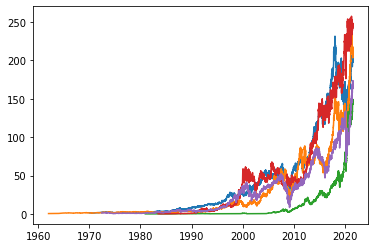

In [121]:
plt.plot(MMM)
plt.plot(CAT)
plt.plot(AAPL)
plt.plot(AMGN)
plt.plot(AXP)

In [122]:
MMM=MMM.tail(37)
AXP=AXP.tail(37)
AAPL=AAPL.tail(37)
AMGN=AMGN.tail(37)
CAT=CAT.tail(37)

In [123]:
stonks=[MMM,AXP,AAPL,AMGN,CAT]

In [124]:
train, test = temporal_train_test_split(MMM, test_size=7)
test_sq=test.squeeze()
train_sq=train.squeeze()
arima = pm.auto_arima(train_sq,error_action='ignore', trace=True,
       suppress_warnings=True, maxiter=100,seasonal=True, m=1)
y_pred = arima.predict(n_periods=test.shape[0])
y_true=test

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=139.404, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=158.962, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=133.698, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=145.659, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=404.588, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=135.804, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=135.657, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=137.505, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.507 seconds


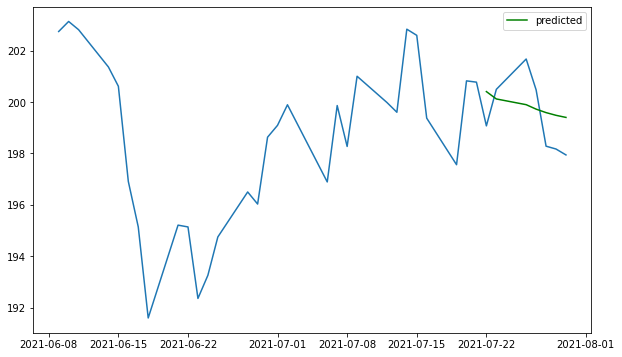

In [125]:
plt.figure(figsize=(10,6))
plt.plot(MMM)
plt.plot(test.index, y_pred, color='green', label = 'predicted')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=139.404, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=158.962, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=133.698, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=145.659, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=404.588, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=135.804, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=135.657, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=137.505, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.509 seconds


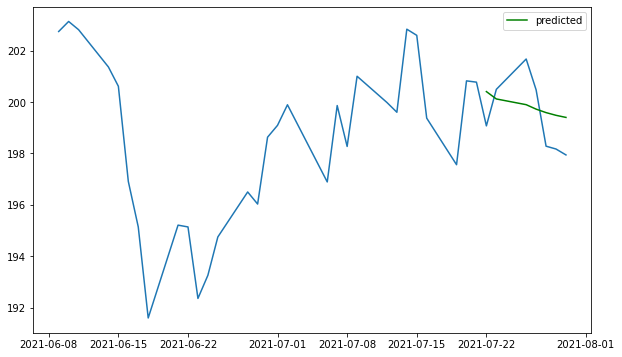

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=150.941, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=152.428, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=151.416, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=149.230, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.404 seconds


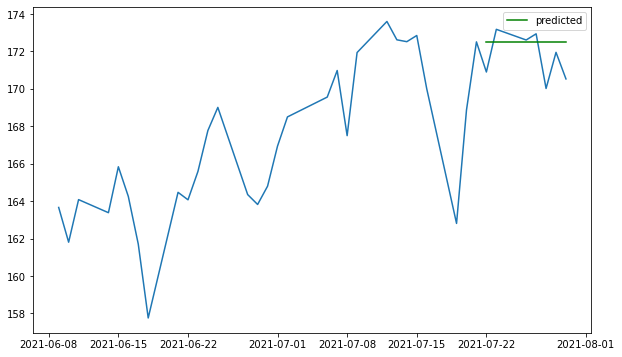

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=119.227, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=120.571, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=120.232, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=120.708, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.396 seconds


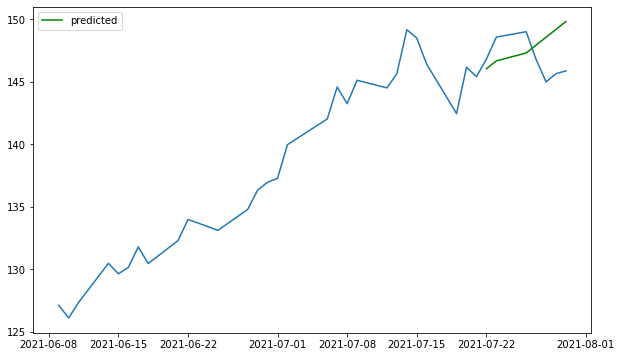

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=123.770, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=125.574, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=124.915, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=122.038, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.277 seconds


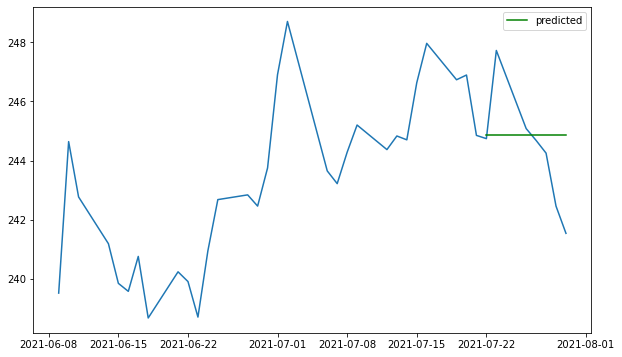

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=159.190, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=160.838, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=160.738, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=158.590, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=162.694, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.293 seconds


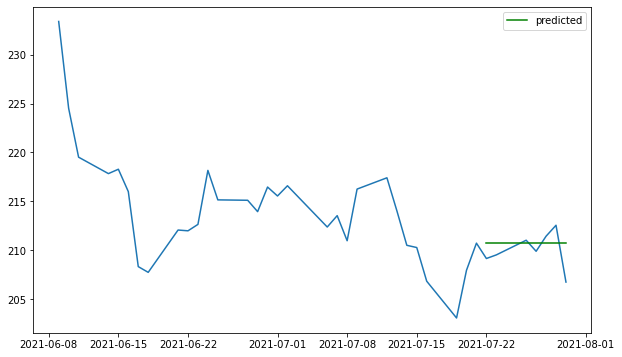

In [126]:
for each in stonks:    
    train, test = temporal_train_test_split(each, test_size=7)
    test_sq=test.squeeze()
    train_sq=train.squeeze()
    arima = pm.auto_arima(train_sq,error_action='ignore', trace=True,
           suppress_warnings=True, maxiter=100,seasonal=True, m=1)
    y_pred = arima.predict(n_periods=test.shape[0])
    y_true=test
    plt.figure(figsize=(10,6))
    plt.plot(each)
    plt.plot(test.index, y_pred, color='green', label = 'predicted')
    plt.legend()
    plt.show()

These results are all pretty terrible. But that's not surprising; ARIMA isn't great for forecasting something like a stock price. 

In the next notebook, we'll try again with Prophet, Facebook's time forecasting library.